<a href="https://colab.research.google.com/github/mikekraehenbuehl/BA_2022_Neural_Network_Bitcoin/blob/main/BA_Kraehenbuehl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import data from Yahoo Finance

First, we import all input features from Yahoo Finance. We take the data starting from 2014-09-15 since there is no earlier data for Bitcoin. In order to keep rows with missing values (N/A's) in the dataset, we merge the features with a left-outer-join together.
Note that Cryptocurrencies are traded every day 24 hours. This is why we have data on weekends as well as public holidays. We have to consider that when creating the train and test datasets.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import pandas_datareader.data as web
import statistics
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

from matplotlib.pyplot import figure

# Setup Pakages

import pandas_datareader as web
from datetime import datetime
import seaborn as sns
import matplotlib as matplot
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
import requests
import json
from pandas.plotting import register_matplotlib_converters


#https://www.relataly.com/stock-market-correlation-matrix-in-python/103/ Yahoo import code from here

# Install Yahoo Finance for first run

!pip install yfinance
!pip install yahoofinancials

import yfinance as yf
from yahoofinancials import YahooFinancials

today_date = datetime.today().strftime("%Y-%m-%d")

start_date = "2014-09-15"
end_date = "2022-04-30"

btc_df = yf.download('BTC-USD', 
                      start='2014-09-15', 
                      end=end_date, 
                      progress=False,
                     )

btc_df_new = btc_df.copy()

# Read the data for different assets

asset_dict = {
    "^GSPC": "SP500",
    "DAX": "DAX",
    "ES=F": "SP500FutJune20",
    "^RUT": "Russell 2000",
    "^VIX": "VIX CBOE",
    "ETH-USD": "ETHUSD",
    "CL=F": "Oil",
    "GC=F": "Gold",
    "^XAU": "Gold/Silver Index",
    "^TNX": "UsTreasuryBond",
    "EURUSD=X": "EURUSD"}

col_list = []

for key, value in asset_dict.items():
    print(key, value)    
    try:
        df_temp = yf.download(key, start=start_date, end=end_date, progress = False)  #today_date
    except ValueError: 
        print(f' {key} symbol not found')
    # convert index to Date Format
    df_temp.index = pd.to_datetime(df_temp.index) 
    df_temp.rename(columns={"Close": value}, inplace=True) # Rename Close Column       
    btc_df_new= pd.merge(
        left=btc_df_new,
        right=df_temp[value],
        how="left", # left-outer-join in order to keep rows with N/As in the dataset
        left_index=True, right_index=True)     

data = btc_df_new
data

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.4 MB 6.2 MB/s 
     |████████████████████████████████| 63 kB 1.4 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for yahoofinancials: filename=yahoofinancials-1.6-py3-none-any.whl size=15192 sha256=8340f33d9ac0d18b81603fc15f43a3e49ca9e4c8827c2a66f2aee43a1a9246be
  Stored in directory: /root/.cache/pip/wheels/4b/63/46/e7110bfee88685fe69e338d1b14d1748921862aa57b6705b60
Successfully built yahoofinancials
^GSPC SP500
DAX DAX
ES=F SP500FutJune20
^RUT Russell 2000
^VIX VIX CBOE
ETH-USD ETHUSD
CL=F Oil
GC=F Gold
^XAU Gold/Silver Index
^TNX UsTreasuryBond
EURUSD=X EURUSD


,Open,High,Low,Close,Adj Close,Volume,SP500,DAX,SP500FutJune20,Russell 2000,VIX CBOE,ETHUSD,Oil,Gold,Gold/Silver Index,UsTreasuryBond,EURUSD
Date,,,,,,,,,,,,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800,2001.569946,NaN,2001.50,1153.890015,12.650000,NaN,94.419998,1234.400024,90.430000,2.600,1.295908
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200,2011.359985,NaN,2012.25,1159.270020,12.030000,NaN,93.070000,1225.699951,89.139999,2.629,1.285000
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700,2010.400024,NaN,2019.25,1146.920044,12.110000,NaN,92.410004,1215.300049,86.930000,2.587,1.292006
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-26,40448.421875,40713.890625,37884.984375,38117.460938,38117.460938,34569088416,4175.200195,26.025999,4170.50,1890.469971,33.520000,2808.298340,101.699997,1901.400024,141.919998,2.772,1.071421
2022-04-27,38120.300781,39397.917969,37997.312500,39241.121094,39241.121094,30981015184,4183.959961,25.910000,4180.25,1884.040039,31.600000,2888.929688,102.019997,1885.900024,141.210007,2.818,1.064362
2022-04-28,39241.429688,40269.464844,38941.421875,39773.828125,39773.828125,33903704907,4287.500000,26.459999,4283.50,1917.939941,29.990000,2936.940918,105.360001,1888.699951,144.080002,2.863,1.055509


In [2]:
# Show first 15 rows: 
# Note that there is daily data for bitcoin and missing values sometimes for other assets.
# Ethereum timeseries starts in 2017. Because it would make our training dataset much smaller, we will not use ETH as an input. 

data[:15]

,Open,High,Low,Close,Adj Close,Volume,SP500,DAX,SP500FutJune20,Russell 2000,VIX CBOE,ETHUSD,Oil,Gold,Gold/Silver Index,UsTreasuryBond,EURUSD
Date,,,,,,,,,,,,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800,2001.569946,NaN,2001.50,1153.890015,12.650000,NaN,94.419998,1234.400024,90.430000,2.600,1.295908
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200,2011.359985,NaN,2012.25,1159.270020,12.030000,NaN,93.070000,1225.699951,89.139999,2.629,1.285000
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700,2010.400024,NaN,2019.25,1146.920044,12.110000,NaN,92.410004,1215.300049,86.930000,2.587,1.292006
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-22,399.100006,406.915985,397.130005,402.152008,402.152008,24127600,1994.290039,NaN,1986.25,1129.359985,13.690000,NaN,91.519997,1216.800049,84.440002,2.566,1.284142
2014-09-23,402.092010,441.557007,396.196991,435.790985,435.790985,45099500,1982.770020,NaN,1972.25,1118.719971,14.930000,NaN,91.559998,1221.000000,85.879997,2.535,1.285149
2014-09-24,435.751007,436.112000,421.131989,423.204987,423.204987,30627700,1998.300049,NaN,1991.00,1128.310059,13.270000,NaN,92.800003,1218.599976,84.980003,2.569,1.285397
2014-09-25,423.156006,423.519989,409.467987,411.574005,411.574005,26814400,1965.989990,NaN,1961.50,1110.239990,15.640000,NaN,92.529999,1221.199951,84.949997,2.511,1.277808


In [3]:
# We drop non-relevant data for Bitcoin

data.drop(
    ["Open", "High", "Low", "Adj Close"],
    axis=1,
    inplace=True,
)
data.rename(columns={"Close": 'BTCUSD Close'}, inplace=True) # Rename Close Column
data.rename(columns={"Volume": 'BTCUSD Volume'}, inplace=True) # Rename Volume Column
data

,BTCUSD Close,BTCUSD Volume,SP500,DAX,SP500FutJune20,Russell 2000,VIX CBOE,ETHUSD,Oil,Gold,Gold/Silver Index,UsTreasuryBond,EURUSD
Date,,,,,,,,,,,,,
2014-09-17,457.334015,21056800,2001.569946,NaN,2001.50,1153.890015,12.650000,NaN,94.419998,1234.400024,90.430000,2.600,1.295908
2014-09-18,424.440002,34483200,2011.359985,NaN,2012.25,1159.270020,12.030000,NaN,93.070000,1225.699951,89.139999,2.629,1.285000
2014-09-19,394.795990,37919700,2010.400024,NaN,2019.25,1146.920044,12.110000,NaN,92.410004,1215.300049,86.930000,2.587,1.292006
2014-09-20,408.903992,36863600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-21,398.821014,26580100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-26,38117.460938,34569088416,4175.200195,26.025999,4170.50,1890.469971,33.520000,2808.298340,101.699997,1901.400024,141.919998,2.772,1.071421
2022-04-27,39241.121094,30981015184,4183.959961,25.910000,4180.25,1884.040039,31.600000,2888.929688,102.019997,1885.900024,141.210007,2.818,1.064362
2022-04-28,39773.828125,33903704907,4287.500000,26.459999,4283.50,1917.939941,29.990000,2936.940918,105.360001,1888.699951,144.080002,2.863,1.055509


## Create Datasets: Prices, Log-Prices, Log-Returns, BTC-Log-Returns

In [4]:
# Prices data
prices = data.copy()
prices

,BTCUSD Close,BTCUSD Volume,SP500,DAX,SP500FutJune20,Russell 2000,VIX CBOE,ETHUSD,Oil,Gold,Gold/Silver Index,UsTreasuryBond,EURUSD
Date,,,,,,,,,,,,,
2014-09-17,457.334015,21056800,2001.569946,NaN,2001.50,1153.890015,12.650000,NaN,94.419998,1234.400024,90.430000,2.600,1.295908
2014-09-18,424.440002,34483200,2011.359985,NaN,2012.25,1159.270020,12.030000,NaN,93.070000,1225.699951,89.139999,2.629,1.285000
2014-09-19,394.795990,37919700,2010.400024,NaN,2019.25,1146.920044,12.110000,NaN,92.410004,1215.300049,86.930000,2.587,1.292006
2014-09-20,408.903992,36863600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-21,398.821014,26580100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-26,38117.460938,34569088416,4175.200195,26.025999,4170.50,1890.469971,33.520000,2808.298340,101.699997,1901.400024,141.919998,2.772,1.071421
2022-04-27,39241.121094,30981015184,4183.959961,25.910000,4180.25,1884.040039,31.600000,2888.929688,102.019997,1885.900024,141.210007,2.818,1.064362
2022-04-28,39773.828125,33903704907,4287.500000,26.459999,4283.50,1917.939941,29.990000,2936.940918,105.360001,1888.699951,144.080002,2.863,1.055509


In [5]:
# Log Prices data
log_prices = np.log(data)
log_prices[2765:]

,BTCUSD Close,BTCUSD Volume,SP500,DAX,SP500FutJune20,Russell 2000,VIX CBOE,ETHUSD,Oil,Gold,Gold/Silver Index,UsTreasuryBond,EURUSD
Date,,,,,,,,,,,,,
2022-04-13,10.625386,24.044377,8.399893,3.313822,8.398916,7.613374,3.082827,8.045057,4.646792,7.591357,5.121699,0.988425,0.079379
2022-04-14,10.595021,23.915469,8.387674,3.307619,8.386515,7.603389,3.122365,8.012982,4.672361,7.586246,5.122534,1.039570,0.085863
2022-04-15,10.610377,23.803195,NaN,NaN,NaN,NaN,NaN,8.019914,NaN,NaN,NaN,NaN,0.078903
2022-04-16,10.607191,23.546616,NaN,NaN,NaN,NaN,NaN,8.026925,NaN,NaN,NaN,NaN,NaN
2022-04-17,10.589533,23.672306,NaN,NaN,NaN,NaN,NaN,8.004166,NaN,NaN,NaN,NaN,NaN
2022-04-18,10.617080,24.240917,8.387469,3.303217,8.386344,7.595955,3.098740,8.025388,4.684074,7.592316,5.122534,1.051521,0.078372
2022-04-19,10.633515,23.954197,8.403399,3.313094,8.402736,7.616170,3.061988,8.040481,4.630448,7.578503,5.097119,1.069184,0.075273
2022-04-20,10.630417,24.049004,8.402781,3.326474,8.401895,7.619817,3.011606,8.031953,4.632299,7.576763,5.107278,1.043804,0.076449
2022-04-21,10.609733,24.289209,8.387918,3.322154,8.387198,7.596623,3.121483,8.002186,4.642370,7.572966,5.052928,1.070556,0.081568


In [6]:
# Log returns

# Note that mondays now also have missing values, because no log-return can be calculated.
log_returns = np.log(prices/prices.shift(1))
log_returns[2765:]

,BTCUSD Close,BTCUSD Volume,SP500,DAX,SP500FutJune20,Russell 2000,VIX CBOE,ETHUSD,Oil,Gold,Gold/Silver Index,UsTreasuryBond,EURUSD
Date,,,,,,,,,,,,,
2022-04-13,0.025576,-0.112602,0.011113,0.012850,0.011149,0.019023,-0.106002,0.028615,0.035640,0.004503,0.022077,-0.014043,-0.004775
2022-04-14,-0.030364,-0.128908,-0.012218,-0.006203,-0.012401,-0.009985,0.039538,-0.032075,0.025570,-0.005111,0.000835,0.051144,0.006484
2022-04-15,0.015355,-0.112274,NaN,NaN,NaN,NaN,NaN,0.006932,NaN,NaN,NaN,NaN,-0.006960
2022-04-16,-0.003186,-0.256579,NaN,NaN,NaN,NaN,NaN,0.007011,NaN,NaN,NaN,NaN,NaN
2022-04-17,-0.017658,0.125690,NaN,NaN,NaN,NaN,NaN,-0.022759,NaN,NaN,NaN,NaN,NaN
2022-04-18,0.027546,0.568611,NaN,NaN,NaN,NaN,NaN,0.021222,NaN,NaN,NaN,NaN,NaN
2022-04-19,0.016435,-0.286720,0.015930,0.009877,0.016392,0.020215,-0.036752,0.015093,-0.053626,-0.013812,-0.025416,0.017663,-0.003099
2022-04-20,-0.003098,0.094807,-0.000619,0.013379,-0.000841,0.003647,-0.050383,-0.008528,0.001851,-0.001740,0.010159,-0.025379,0.001176
2022-04-21,-0.020684,0.240204,-0.014863,-0.004320,-0.014696,-0.023194,0.109878,-0.029767,0.010071,-0.003798,-0.054350,0.026752,0.005119


In [7]:
# Log retruns Bitcoin
log_ret_btc = pd.DataFrame(log_returns['BTCUSD Close'])
log_ret_btc

,BTCUSD Close
Date,
2014-09-17,NaN
2014-09-18,-0.074643
2014-09-19,-0.072402
2014-09-20,0.035111
2014-09-21,-0.024968
...,...
2022-04-26,-0.059600
2022-04-27,0.029053
2022-04-28,0.013484


# Create Input-Datasets (Lag 1)

In a first step, we select different features from the log_returns-dataset that we want to compare for a Bitcoin prediction with a neural network. We combine the features log-returns (inputs) together with the Bitcoin log-returns (target). Each feature gets delayed by 1 day (t-1). Based on these features we train a neural network in order to predict the Bitcoin price movement at time t. All rows that include a missing value (N/A) will be removed.

#### Create Lag 1

In [10]:
# Drop inputs Function (used later to create different input Datasets)

def drop_inputs(to_drop, full_data):
  full_dat = full_data.copy()
  full_dat.drop(
          to_drop,
    axis=1,
    inplace=True,)
  return full_dat
  
  # This will be the complete dataset with all selected features and the Bitcoin target. Each feature is delayed by 1 day (lag1).

# Function to create full lagged dataset:

df = pd.DataFrame()

def create_full1(data, btc, empty):

  lag1_btc = data['BTCUSD Close'].shift(1)            # create lag of input
  lag1_sp500 = data['SP500'].shift(1)
  lag1_russell = data['Russell 2000'].shift(1)
  lag1_eurusd = data['EURUSD'].shift(1)
  lag1_ustreasurybond = data['UsTreasuryBond'].shift(1)
  lag1_goldsilver = data['Gold/Silver Index'].shift(1)
  


  empty['Bitcoin'] = btc                   # add BTC log ret as target

  empty['lag1_btc'] = lag1_btc                     # add lag of Inputs
  empty['lag1_sp500'] = lag1_sp500
  empty['lag1_russell'] = lag1_russell
  empty['lag1_EurUsd'] = lag1_eurusd
  empty['lag1_ustreasurybond'] = lag1_ustreasurybond
  empty['lag1_goldsilver'] = lag1_goldsilver

  empty = empty.dropna()                   # drop NA values created because of lag

  return empty

In [11]:
# Call function and save full lagged dataset as "full" (rows with missing values deleted)

full = create_full1(log_returns, log_ret_btc, df)
full

,Bitcoin,lag1_btc,lag1_sp500,lag1_russell,lag1_EurUsd,lag1_ustreasurybond,lag1_goldsilver
Date,,,,,,,
2014-09-19,-0.072402,-0.074643,0.004879,0.004652,-0.008452,0.011092,-0.014368
2014-09-20,0.035111,-0.072402,-0.000477,-0.010710,0.005437,-0.016105,-0.025105
2014-09-24,-0.029306,0.080333,-0.005793,-0.009466,0.000784,-0.012155,0.016910
2014-09-25,-0.027868,-0.029306,0.007802,0.008536,0.000193,0.013323,-0.010535
2014-09-26,-0.017523,-0.027868,-0.016301,-0.016145,-0.005921,-0.022836,-0.000353
...,...,...,...,...,...,...,...
2022-04-23,-0.006402,-0.019611,-0.028132,-0.025840,-0.001355,-0.003778,-0.034722
2022-04-27,0.029053,-0.059600,-0.028550,-0.033155,-0.008998,-0.019293,-0.026972
2022-04-28,0.013484,0.029053,0.002096,-0.003407,-0.006610,0.016458,-0.005015


## **Choose dataset**

## BTC same day ( only for test )

In [ ]:
df = pd.DataFrame()

def btc_sameday(data, btc, empty):

  empty['Bitcoin'] = btc                   # add BTC log ret as target

  empty['same day btc'] = btc               # add lag of Input

  empty = empty.dropna()                   # drop NA values created because of lag

  return empty

In [ ]:
x = btc_sameday(log_returns, log_ret_btc, df)
x

,Bitcoin,same day btc
Date,,
2014-09-18,-0.074643,-0.074643
2014-09-19,-0.072402,-0.072402
2014-09-20,0.035111,0.035111
2014-09-21,-0.024968,-0.024968
2014-09-22,0.008317,0.008317
...,...,...
2022-04-26,-0.059600,-0.059600
2022-04-27,0.029053,0.029053
2022-04-28,0.013484,0.013484


## ETH same day (only for test)

In [ ]:
df = pd.DataFrame()

feature_same_day = 'ETHUSD'   

def sp500_sameday(data, feature_sd, empty):

  empty['Bitcoin'] = data['BTCUSD Close']                  # add BTC log ret as target

  empty[feature_sd] = data[feature_sd]               # add lag of Input

  empty = empty.dropna()                   # drop NA values created because of lag

  return empty

In [ ]:
x = sp500_sameday(log_returns, feature_same_day, df)
x

,Bitcoin,ETHUSD
Date,,
2017-11-10,-0.076400,-0.069790
2017-11-11,-0.040163,0.050270
2017-11-12,-0.066248,-0.021758
2017-11-13,0.097510,0.028204
2017-11-14,0.011559,0.063948
...,...,...
2022-04-26,-0.059600,-0.069160
2022-04-27,0.029053,0.028307
2022-04-28,0.013484,0.016482


In [ ]:
# calculate Pearson's correlation
corr, _ = pearsonr(x['Bitcoin'], x[feature_same_day])
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.778


## Normal Distribution

In [110]:
x = pd.DataFrame(full['Bitcoin'])
np.random.seed(1)

# loc: Mean of the distribution. Default is 0.
# scale: Standard deviation of the distribution. Default is 1.
# size: Sample size.

loc = 0 #np.mean(full['Bitcoin'])
size = len(full['Bitcoin'])
scale = np.std(full['Bitcoin'])

rnorm_sample = np.random.normal(loc=loc, scale=scale, size=size)

x['rNorm'] = rnorm_sample

x

,Bitcoin,rNorm
Date,,
2014-09-19,-0.072402,0.066050
2014-09-20,0.035111,-0.024876
2014-09-24,-0.029306,-0.021477
2014-09-25,-0.027868,-0.043630
2014-09-26,-0.017523,0.035190
...,...,...
2022-04-23,-0.006402,-0.065859
2022-04-27,0.029053,0.081534
2022-04-28,0.013484,-0.007629


## Lag 1: Bitcoin (1495 rows)

In [75]:
x = drop_inputs(['lag1_sp500', 'lag1_goldsilver', 'lag1_ustreasurybond', 'lag1_EurUsd', 'lag1_russell'], full)
x

,Bitcoin,lag1_btc
Date,,
2014-09-19,-0.072402,-0.074643
2014-09-20,0.035111,-0.072402
2014-09-24,-0.029306,0.080333
2014-09-25,-0.027868,-0.029306
2014-09-26,-0.017523,-0.027868
...,...,...
2022-04-23,-0.006402,-0.019611
2022-04-27,0.029053,-0.059600
2022-04-28,0.013484,0.029053


## Lag 1: Bitcoin (2781 rows)

In [ ]:
# only Bitcoin lag 1 as feature (all rows since start)

df = pd.DataFrame()

def btc_full(data, btc, empty):

  lag1_btc = data['BTCUSD Close'].shift(1)            # create lag of input


  empty['Bitcoin'] = btc                   # add BTC log ret as target

  empty['lag1_btc'] = lag1_btc                     # add lag of Inputs

  empty = empty.dropna()                   # drop NA values created because of lag

  return empty

In [ ]:
# Call function and save full lagged dataset as "full"

x = btc_full(log_returns, log_ret_btc, df)
x

,Bitcoin,lag1_btc
Date,,
2014-09-19,-0.072402,-0.074643
2014-09-20,0.035111,-0.072402
2014-09-21,-0.024968,0.035111
2014-09-22,0.008317,-0.024968
2014-09-23,0.080333,0.008317
...,...,...
2022-04-26,-0.059600,0.024749
2022-04-27,0.029053,-0.059600
2022-04-28,0.013484,0.029053


## Lag 1: Bitcoin, S&P500

In [ ]:
x = drop_inputs(['lag1_goldsilver', 'lag1_ustreasurybond', 'lag1_EurUsd', 'lag1_russell'], full)
x

,Bitcoin,lag1_btc,lag1_sp500
Date,,,
2014-09-19,-0.072402,-0.074643,0.004879
2014-09-20,0.035111,-0.072402,-0.000477
2014-09-24,-0.029306,0.080333,-0.005793
2014-09-25,-0.027868,-0.029306,0.007802
2014-09-26,-0.017523,-0.027868,-0.016301
...,...,...,...
2022-04-23,-0.006402,-0.019611,-0.028132
2022-04-27,0.029053,-0.059600,-0.028550
2022-04-28,0.013484,0.029053,0.002096


## Lag 1: Bitcoin, S&P500, Russell2000

In [ ]:
x = drop_inputs(['lag1_goldsilver', 'lag1_ustreasurybond', 'lag1_EurUsd'], full)
x

,Bitcoin,lag1_btc,lag1_sp500,lag1_russell
Date,,,,
2014-09-19,-0.072402,-0.074643,0.004879,0.004652
2014-09-20,0.035111,-0.072402,-0.000477,-0.010710
2014-09-24,-0.029306,0.080333,-0.005793,-0.009466
2014-09-25,-0.027868,-0.029306,0.007802,0.008536
2014-09-26,-0.017523,-0.027868,-0.016301,-0.016145
...,...,...,...,...
2022-04-23,-0.006402,-0.019611,-0.028132,-0.025840
2022-04-27,0.029053,-0.059600,-0.028550,-0.033155
2022-04-28,0.013484,0.029053,0.002096,-0.003407


## Lag 1: Bitcoin, S&P500, Russell2000, EUR/USD

In [ ]:
x = drop_inputs(['lag1_goldsilver', 
                 'lag1_ustreasurybond'], full)
x

,Bitcoin,lag1_btc,lag1_sp500,lag1_russell,lag1_EurUsd
Date,,,,,
2014-09-19,-0.072402,-0.074643,0.004879,0.004652,-0.008452
2014-09-20,0.035111,-0.072402,-0.000477,-0.010710,0.005437
2014-09-24,-0.029306,0.080333,-0.005793,-0.009466,0.000784
2014-09-25,-0.027868,-0.029306,0.007802,0.008536,0.000193
2014-09-26,-0.017523,-0.027868,-0.016301,-0.016145,-0.005921
...,...,...,...,...,...
2022-04-23,-0.006402,-0.019611,-0.028132,-0.025840,-0.001355
2022-04-27,0.029053,-0.059600,-0.028550,-0.033155,-0.008998
2022-04-28,0.013484,0.029053,0.002096,-0.003407,-0.006610


## Lag 1: Bitcoin, S&P500, Russell2000, EUR/USD, 10Y Treasury Yield

In [ ]:
x = drop_inputs(['lag1_goldsilver'], full)
x

,Bitcoin,lag1_btc,lag1_sp500,lag1_russell,lag1_EurUsd,lag1_ustreasurybond
Date,,,,,,
2014-09-19,-0.072402,-0.074643,0.004879,0.004652,-0.008452,0.011092
2014-09-20,0.035111,-0.072402,-0.000477,-0.010710,0.005437,-0.016105
2014-09-24,-0.029306,0.080333,-0.005793,-0.009466,0.000784,-0.012155
2014-09-25,-0.027868,-0.029306,0.007802,0.008536,0.000193,0.013323
2014-09-26,-0.017523,-0.027868,-0.016301,-0.016145,-0.005921,-0.022836
...,...,...,...,...,...,...
2022-04-23,-0.006402,-0.019611,-0.028132,-0.025840,-0.001355,-0.003778
2022-04-27,0.029053,-0.059600,-0.028550,-0.033155,-0.008998,-0.019293
2022-04-28,0.013484,0.029053,0.002096,-0.003407,-0.006610,0.016458


## Lag 1: Bitcoin, S&P500, Russell2000, EUR/USD, 10Y Treasury Yield, Gold/Silver

In [12]:
x = full # full dataset as defined earlier
x

,Bitcoin,lag1_btc,lag1_sp500,lag1_russell,lag1_EurUsd,lag1_ustreasurybond,lag1_goldsilver
Date,,,,,,,
2014-09-19,-0.072402,-0.074643,0.004879,0.004652,-0.008452,0.011092,-0.014368
2014-09-20,0.035111,-0.072402,-0.000477,-0.010710,0.005437,-0.016105,-0.025105
2014-09-24,-0.029306,0.080333,-0.005793,-0.009466,0.000784,-0.012155,0.016910
2014-09-25,-0.027868,-0.029306,0.007802,0.008536,0.000193,0.013323,-0.010535
2014-09-26,-0.017523,-0.027868,-0.016301,-0.016145,-0.005921,-0.022836,-0.000353
...,...,...,...,...,...,...,...
2022-04-23,-0.006402,-0.019611,-0.028132,-0.025840,-0.001355,-0.003778,-0.034722
2022-04-27,0.029053,-0.059600,-0.028550,-0.033155,-0.008998,-0.019293,-0.026972
2022-04-28,0.013484,0.029053,0.002096,-0.003407,-0.006610,0.016458,-0.005015


# Create Input-Datasets (Lag 2) not used in bachelors thesis

In a first step, we select different features from the log_returns-dataset that we want to compare for a Bitcoin-prediction with a neural network. We combine the features-log-returns (inputs) together with the bitcoin-log-retunrs (target). Each feature gets delayed by 1 and 2 days (t-1 & t-2). based on these features we train a neural network in order to predict the bitcoin price (t).

In [ ]:
# Drop inputs Function (used later to create seperate Input-Datasets for comparison)

def drop_inputs(to_drop, full_data):
  full_dat = full_data.copy()
  full_dat.drop(
          to_drop,
    axis=1,
    inplace=True,)
  return full_dat



# This will be the complete dataset with all selected features and the bitcoin. Each feature is delayed by 1 and 2 days (lag1 & lag2).

# Function to create full lagged dataset:

df = pd.DataFrame()

def create_full2(data, btc, empty):

  lag1_btc = data['BTCUSD Close'].shift(1)            # create lag of input
  lag2_btc = data['BTCUSD Close'].shift(2)
  lag1_sp500 = data['SP500'].shift(1)
  lag2_sp500 = data['SP500'].shift(2)
  lag1_russell = data['Russell 2000'].shift(1)
  lag2_russell = data['Russell 2000'].shift(2)
  lag1_eurusd = data['EURUSD'].shift(1)
  lag2_eurusd = data['EURUSD'].shift(2)
  lag1_ustreasurybond = data['UsTreasuryBond'].shift(1)
  lag2_ustreasurybond = data['UsTreasuryBond'].shift(2)
  lag1_goldsilver = data['Gold/Silver Index'].shift(1)
  lag2_goldsilver = data['Gold/Silver Index'].shift(2)
  


  empty['Bitcoin'] = btc                   # add BTC log ret as target

  empty['lag1_btc'] = lag1_btc                     # add lag of Inputs
  empty['lag2_btc'] = lag2_btc
  empty['lag1_sp500'] = lag1_sp500
  empty['lag2_sp500'] = lag2_sp500 
  empty['lag1_russell'] = lag1_russell
  empty['lag2_russell'] = lag2_russell
  empty['lag1_EurUsd'] = lag1_eurusd
  empty['lag2_EurUsd'] = lag2_eurusd
  empty['lag1_ustreasurybond'] = lag1_ustreasurybond
  empty['lag2_ustreasurybond'] = lag2_ustreasurybond
  empty['lag1_goldsilver'] = lag1_goldsilver
  empty['lag2_goldsilver'] = lag2_goldsilver

  empty = empty.dropna()                   # drop NA values created because of lag

  return empty


# Call function and save full lagged dataset as "full"

full = create_full2(log_returns, log_ret_btc, df)
full

'''
# Lag 2: Bitcoin
x = drop_inputs(['lag1_sp500','lag2_sp500', 'lag1_goldsilver', 'lag2_goldsilver', 
                 'lag1_ustreasurybond', 'lag2_ustreasurybond', 'lag1_EurUsd', 'lag2_EurUsd', 'lag1_russell', 'lag2_russell'], full)

## Lag 2: Bitcoin, S&P500
x = drop_inputs(['lag1_goldsilver', 'lag2_goldsilver', 
                 'lag1_ustreasurybond', 'lag2_ustreasurybond', 'lag1_EurUsd', 'lag2_EurUsd', 'lag1_russell', 'lag2_russell'], full)

## Lag 2: Bitcoin, S&P500, Russell200
x = drop_inputs(['lag1_goldsilver', 'lag2_goldsilver', 
                 'lag1_ustreasurybond', 'lag2_ustreasurybond', 'lag1_EurUsd', 'lag2_EurUsd'], full)

## Lag 2: Bitcoin, S&P500, Russell2000, EUR/USD
x = drop_inputs(['lag1_goldsilver', 'lag2_goldsilver', 
                 'lag1_ustreasurybond', 'lag2_ustreasurybond'], full)

## Lag 2: Bitcoin, S&P500, Russell2000, EUR/USD, 10Y Treasury Yield
x = drop_inputs(['lag1_goldsilver', 'lag2_goldsilver'], full)
'''

## Lag 2: Bitcoin, S&P500, Russell2000, EUR/USD, 10Y Treasury Yield, Gold/Silver
x = full

x

# Create scaled Train and Test datasets

Here we seperate the dataset from before into x_train, y_train, x_test, y_test. The x_datasets will then contain normalized lagged log returns of the selected input features. The y_datasets will contain the target that is defined as binary Bitcoin signal (1 if positive log return, 0 if negative log return). The train dataset represents the first 60% of data and the test dataset represents the remaining 40%.

In [13]:
column_names = x.columns

# scaling / normalize features to 0-1

from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))

scaled_x = sc.fit_transform(x.loc[:, x.columns != 'Bitcoin'])  # normalize dataset, except the target Bitcoin
scaled_x = pd.DataFrame(scaled_x)

idx = 0
btc_unscaled = pd.DataFrame(x['Bitcoin'])  
scaled_x.insert(loc=idx, column='Bitcoin', value=btc_unscaled) # insert log returns of Bitcoin to dataset

scaled_dat = scaled_x  # continue with dataset "scaled_dat"
scaled_dat

,Bitcoin,0,1,2,3,4,5
0,-0.072402,0.565467,0.552788,0.591480,0.349828,0.417645,0.453152
1,0.035111,0.568717,0.524540,0.517745,0.596587,0.377416,0.416202
2,-0.029306,0.790119,0.496507,0.523718,0.513911,0.383259,0.560789
3,-0.027868,0.631187,0.568201,0.610124,0.503413,0.420945,0.466342
4,-0.017523,0.633272,0.441095,0.491660,0.394801,0.367460,0.501381
...,...,...,...,...,...,...,...
1490,-0.006402,0.645241,0.378703,0.445125,0.475911,0.395649,0.383107
1491,0.029053,0.587274,0.376499,0.410012,0.340145,0.372700,0.409775
1492,0.013484,0.715784,0.538110,0.552800,0.382556,0.425582,0.485337
1493,-0.029702,0.693215,0.655971,0.654750,0.351610,0.424671,0.571838


In [14]:
# Split dataset into x_train, y_train, x_test, y_test at a train-level of 60%

def train_test_split(scaled_dat):

# First: split the dataset in two parts: train and test at a specific train level

  train_lvl = 0.6     # use 60% of the data for training
  train_test_split_idx = int(len(scaled_dat)*train_lvl)
  scaled_dat = pd.DataFrame(scaled_dat)

  train = scaled_dat.iloc[:train_test_split_idx,:]
  test = scaled_dat.iloc[train_test_split_idx:,:]
  

# Second: separate explanotary vairiables (x) from target (y = bitcoin)

  x_train = train.iloc[:,1:x.shape[1]]
  y_train = train.iloc[:,0]

  x_test = test.iloc[:,1:x.shape[1]]
  y_test = test.iloc[:,0]
  return x_train, x_test, y_train, y_test, train_test_split_idx, train_lvl

# call split-function
x_train, x_test, y_train, y_test , train_test_split_idx, train_lvl = train_test_split(scaled_dat)

In [15]:
y_train_log_return = y_train.copy()
y_test_log_return  = y_test.copy()

# Change target (Bitcoin log returns to binary signal)
y_train = (y_train > 0).astype(int)
y_test = (y_test > 0).astype(int)

# Change datatype
y_train = pd.DataFrame(y_train)  
y_test = pd.DataFrame(y_test)

y_train

,Bitcoin
0,0
1,1
2,0
3,0
4,0
...,...
892,1
893,1
894,1
895,1


# Loop the model

Now we have 4 datasets:

x_train = lagged input features for model training

y_train = target (Bitcoin signal) for model training

x_test  = lagged input features for model testing/validation

y_test = target (Bitcoin signal) for model testing/validation



We create a simple feed-forward-neural-network with a loop option (since parameters are set randomly with each iteration). As activation function in hidden layers we use 'relu' rectified linear unit. In the output layer we use a sigmoid activation function to map the output to a probability for the signal being positive. The loss function is defined as binary crossentropy, ideal for this binary classification problem.

For each iteration, we save the accuracy (percentage of correctly predicted signals out-of-sample), cumsum (cumulative log returns / performance achieved with our predicted trading signals), in-sample-loss (Loss in training sample), out-of-sample-loss (Loss in validation sample), etc.

In [114]:
out_samp_accuracy = []
cumsum = []
in_samp_loss = []
out_samp_loss = []
in_samp_acc = []
loss_hist = []
val_loss_hist = []
acc_hist = []
val_acc_hist = []
tot_cumsum = []
weights_tot = []
sum_pred_binary_hist = []
sharpe_ratio_hist = []


loops = 50                # choose how many iterations/loops



for i in range(0, loops):

  print("######################  Iteration ", i, " of ", loops," ##########################")

  opt = tf.keras.optimizers.Adam(learning_rate=0.00005)  # use Adam with learning rate 0.00005

  model = tf.keras.models.Sequential([ 
                                      tf.keras.layers.Dense(30, activation='relu', input_shape =(x_train.shape[1],),),
                                      tf.keras.layers.BatchNormalization(),
                                      tf.keras.layers.Dense(15, activation='relu',),
                                      tf.keras.layers.BatchNormalization(),
                                      tf.keras.layers.Dense(5, activation='relu',),
                                      tf.keras.layers.BatchNormalization(),
                                      tf.keras.layers.Dense(1, activation='sigmoid')])
  
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

  # Train the model with normalized log-return inputs and binary target variable
  history = model.fit(x_train, y_train, epochs=300, batch_size = 20, validation_split = 0.1)    # validation_split: take 10% of training data to validate perfomance during training

  
  # Save final model weights

  weights_iteration = []
  for layer in model.layers:
     weights = layer.get_weights()
     weights_iteration.append(weights)
  weights_tot.append(weights_iteration)    # append weights to list for this loop

  # Get the predicted values

  predictions = model.predict(x_test)             # make predictions based on test set inputs (output is probability for the signal being positive)
  pred_binary = np.round(predictions)             # predicted signal with probability >0.5 will be 1, and <0.5 will be 0
  

  target_eff = pd.DataFrame(y_test_log_return)    # effective Bitcoin log returns during test period

  perf_nn = pred_binary*target_eff                # calculate returns when signal = 1 or "in the market" (predicted signal * effective log returns)
  cum_perf_nn = np.cumsum(perf_nn)                # cumulative sum over (predicted signals * effective log returns)
  cumsum_tot = cum_perf_nn.iloc[-1]
  sharpe_nn = np.sqrt(252)*np.mean(perf_nn)/np.sqrt(np.var(perf_nn)) # calculate sharpe_ratio

  acc_temp = 0                                    # count of correctly predicted signals
  y_test = np.array(y_test)
  for i in range(0,len(pred_binary)):             # add +1 to count when prediction signal = effective signal
    if pred_binary[i] == y_test[i]:
      acc_temp += 1

  acc_perc = acc_temp/len(pred_binary)            # percentage of correctly predicted signals (out-of-sample)
  out_samp_accuracy.append(acc_perc)              # append accuracy to list for this loop

  cumsum.append(cum_perf_nn)                                   # append cumsum to list for this loop
  tot_cumsum.append(cum_perf_nn[len(cum_perf_nn)-1:])          # append total cumsum (final performance) for this loop
  in_samp_loss.append(model.evaluate(x_train, y_train)[0])     # append in-sample-loss (training set)
  out_samp_loss.append(model.evaluate(x_test, y_test)[0])      # append out-of-sample-loss (validation set)
  in_samp_acc.append(model.evaluate(x_train, y_train)[1])      # append in-sample-accuracy (training set)
  loss_hist.append(history.history['loss'])                    # append loss (binary crossentropy)-history for plot later
  val_loss_hist.append(history.history['val_loss'])            # append validation-loss (binary crossentropy)-history for plot later
  acc_hist.append(history.history['accuracy'])                 # append accuracy (in-sample) history for plot later
  val_acc_hist.append(history.history['val_accuracy'])         # append accuracy (validation) history for plot later
  sum_pred_binary_hist.append(sum(pred_binary))                # append amount of predicted positive (1) signals
  sharpe_ratio_hist.append(sharpe_nn)                          # append sharpe ratio

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
Epoch 219/300
41/41 [==============================] - 0s 9ms/step - loss: 0.6882 - accuracy: 0.5291 - val_loss: 0.6687 - val_accuracy: 0.6222
Epoch 220/300
41/41 [==============================] - 0s 6ms/step - loss: 0.6915 - accuracy: 0.5279 - val_loss: 0.6620 - val_accuracy: 0.6111
Epoch 221/300
41/41 [==============================] - 0s 6ms/step - loss: 0.6860 - accuracy: 0.5452 - val_loss: 0.6533 - val_accuracy: 0.6111
Epoch 222/300
41/41 [==============================] - 0s 6ms/step - loss: 0.6850 - accuracy: 0.5514 - val_loss: 0.6633 - val_accuracy: 0.6111
Epoch 223/300
41/41 [==============================] - 0s 6ms/step - loss: 0.6842 - accuracy: 0.5390 - val_loss: 0.6545 - val_accuracy: 0.6111
Epoch 224/300
41/41 [==============================] - 0s 6ms/step - loss: 0.6835 - accuracy: 0.5663 - val_loss: 0.6537 - val_accuracy: 0.6111
Epoch 225/300
41/41 [==============================] - 0s 6ms/step - loss: 

# Evaluate Model Predictions

The model has now been trained and generated predictions. The predictions have been transformed to signals (0 & 1). Following we analyze the single outputs for each iteration, as well as averages over the iterations.

## Single results

In [115]:
# In-sample loss of each iteration (train)
print("in-sample-loss:                     ", in_samp_loss)

# Out-of-sample loss (validation)
print("out-of-sample-loss:                 ", out_samp_loss)

# Accuracy (out sample) for each loop (percentage of signals correctly predicted in test dataset)
print("out-of-sample-accuracy:             ", out_samp_accuracy)

# Average prediction accuracy (percentage of correctly predicted signals)
average_accuracy = sum(out_samp_accuracy)/len(out_samp_accuracy)
print("average accuracy (out-sample):      ", average_accuracy)

# Percentage of effective positive returns (in test dataset)
eff_perc_pos_returns = sum(y_test)/len(y_test)
print("buy-and-hold accuracy (out-sample): ", (sum(y_test)/len(y_test))[0])

# Total cumulative log-returns (out sample performance)
print("total cumsum:                       ", np.transpose(np.array(tot_cumsum)[0:,0]))

# Average cumsum of log-returns over all iterations
average_cumsum = sum(tot_cumsum)/len(tot_cumsum)
print("average cumsum:                     ", np.array(average_cumsum))

# Effective cumulative log-returns (last element of effective log cumsum)
eff_cumsum = np.cumsum(target_eff)
print("effective cumsum:                   ", np.array(eff_cumsum[len(eff_cumsum)-1:])[0])

# Sharpe Ratio for each iteration
print("sharpe ratios (out-of-sample):      ", np.transpose(np.array(sharpe_ratio_hist))[0])

# Average Sharpe Ration over all iterations
print("average sharpe ratio:               ", np.array(sum(sharpe_ratio_hist)/len(sharpe_ratio_hist)))

# Buy-and-Hold Sharpe Ratio
eff_sharpe_nn = np.sqrt(252)*np.mean(target_eff)/np.sqrt(np.var(target_eff))
print("buy-and-hold sharpe ratio:          ", np.array(eff_sharpe_nn))

# final weights of one iteration in loop
# weights_tot[0]

in-sample-loss:                      [0.6982619762420654, 0.6883957982063293, 0.6841129064559937, 0.6890692710876465, 0.6880859732627869, 0.6849399209022522, 0.6983984112739563, 0.6859799027442932, 0.688621997833252, 0.6897435784339905, 0.6877345442771912, 0.6836196780204773, 0.6838504672050476, 0.6953953504562378, 0.6845191717147827, 0.6916665434837341, 0.6886977553367615, 0.688293993473053, 0.6927739977836609, 0.6861097812652588, 0.6819033622741699, 0.6821707487106323, 0.6853006482124329, 0.6875392198562622, 0.6851659417152405, 0.6865180134773254, 0.6829356551170349, 0.6864686608314514, 0.6853958964347839, 0.6997396945953369, 0.6886295080184937, 0.687425971031189, 0.6838922500610352, 0.6848559379577637, 0.6865651607513428, 0.6997498869895935, 0.6849244236946106, 0.6837736368179321, 0.6883754730224609, 0.6839401721954346, 0.6865934133529663, 0.6859956979751587, 0.6837575435638428, 0.6848071217536926, 0.6857496500015259, 0.6893219351768494, 0.6821216344833374, 0.6858471035957336, 0.689

average 1 s predicted:  534.0
number of predictions:  598


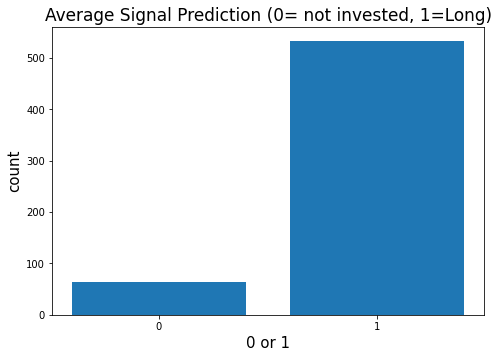

In [125]:
zeros = len(y_test)-np.round(sum(sum_pred_binary_hist)/len(sum_pred_binary_hist))[0]
ones = np.round(sum(sum_pred_binary_hist)/len(sum_pred_binary_hist))[0]
h = [zeros, ones]

print('average 1 s predicted: ', ones)
print('number of predictions: ',len(pred_binary))


fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
plt.xlabel("0 or 1", fontsize=15)
plt.ylabel('count', fontsize=15)
plt.title("Average Signal Prediction (0= not invested, 1=Long)", fontsize=17)
signal = ['0', '1']
count = [zeros,ones]
ax.bar(signal,count)
plt.show()

## Loss-Plot and Cumsum-Plot

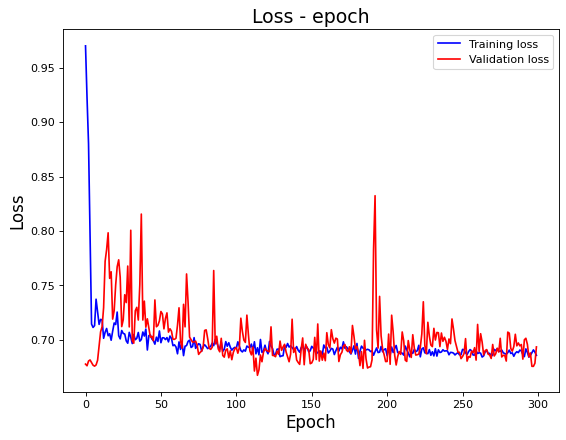

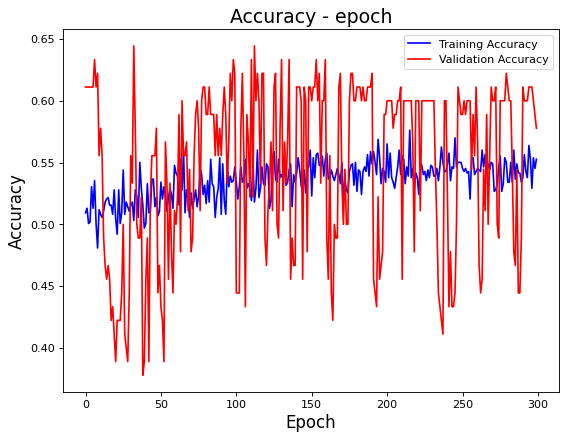

In [126]:
# binary crossentropy-loss for each epoch

iteration = 0                       # choose which iteration to show in plot

loss = loss_hist[iteration]
val_loss = val_loss_hist[iteration]
accuracy = acc_hist[iteration]
val_accuracy = val_acc_hist[iteration]                    

plt.figure(figsize=(8, 6), dpi=80)
plt.plot(loss, 'b', label='Training loss')
plt.plot(val_loss, 'r', label='Validation loss')
plt.title("Loss - epoch", fontsize=17)
plt.xlabel("Epoch", fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.legend()

plt.figure(figsize=(8, 6), dpi=80)
plt.plot(accuracy, 'b', label='Training Accuracy')
plt.plot(val_accuracy, 'r', label='Validation Accuracy')
plt.title("Accuracy - epoch", fontsize=17)
plt.xlabel("Epoch", fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.legend()

plt.show()


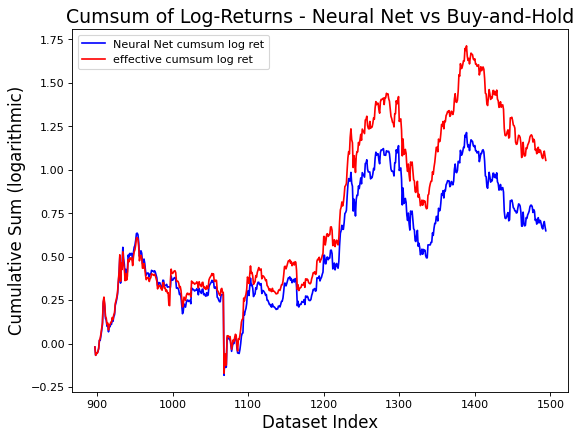

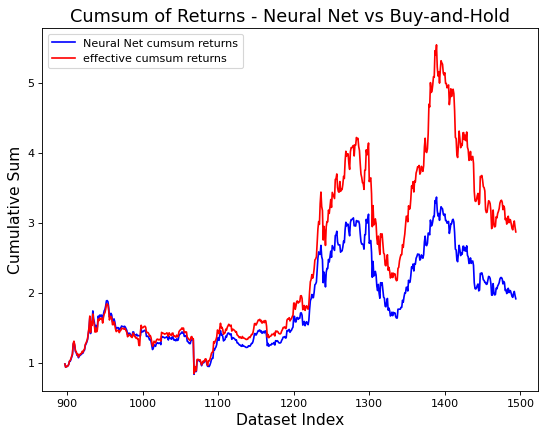

In [118]:
# Cumulative log-returns: effective VS preciction

which = 0                          # choose which iteration to show in plot

plt.figure(figsize=(8, 6), dpi=80)
plt.plot(cumsum[which], 'b', label='Neural Net cumsum log ret')
plt.plot(np.cumsum(target_eff), 'r', label='effective cumsum log ret')
plt.title("Cumsum of Log-Returns - Neural Net vs Buy-and-Hold", fontsize=17)
plt.xlabel("Dataset Index", fontsize=15)
plt.ylabel('Cumulative Sum (logarithmic)', fontsize=15)
plt.legend()

plt.figure(figsize=(8, 6), dpi=80)
plt.plot(np.exp(cumsum[which]), 'b', label='Neural Net cumsum returns')
plt.plot(np.exp(np.cumsum(target_eff)), 'r', label='effective cumsum returns')
plt.title("Cumsum of Returns - Neural Net vs Buy-and-Hold")
plt.xlabel("Dataset Index")
plt.ylabel('Cumulative Sum')
plt.legend()

plt.show()

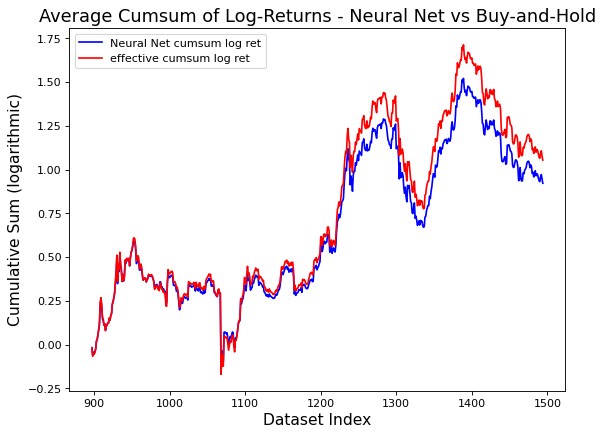

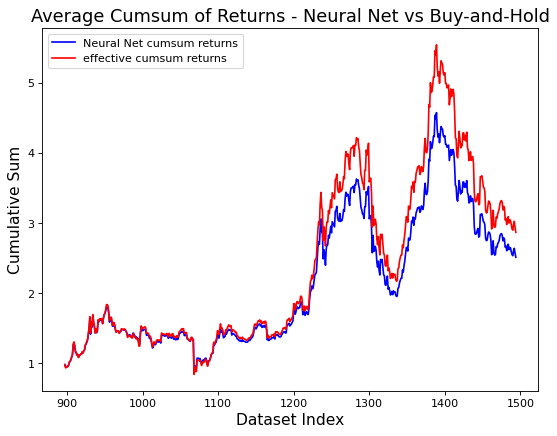

In [119]:
# Average Cumulative log-returns over all iterations: effective VS preciction

cumsum_average = sum(cumsum)/len(cumsum)

plt.show()

parameters = {'axes.labelsize': 14,
          'axes.titlesize': 16}
plt.rcParams.update(parameters)

plt.figure(figsize=(8, 6), dpi=80)
plt.plot(cumsum_average, 'b', label='Neural Net cumsum log ret')
plt.plot(np.cumsum(target_eff), 'r', label='effective cumsum log ret')
plt.title("Average Cumsum of Log-Returns - Neural Net vs Buy-and-Hold")
plt.xlabel("Dataset Index")
plt.ylabel('Cumulative Sum (logarithmic)')
plt.legend()

plt.figure(figsize=(8, 6), dpi=80)
plt.plot(np.exp(cumsum_average), 'b', label='Neural Net cumsum returns')
plt.plot(np.exp(np.cumsum(target_eff)), 'r', label='effective cumsum returns')
plt.title("Average Cumsum of Returns - Neural Net vs Buy-and-Hold")
plt.xlabel("Dataset Index")
plt.ylabel('Cumulative Sum')
plt.legend()

plt.show()

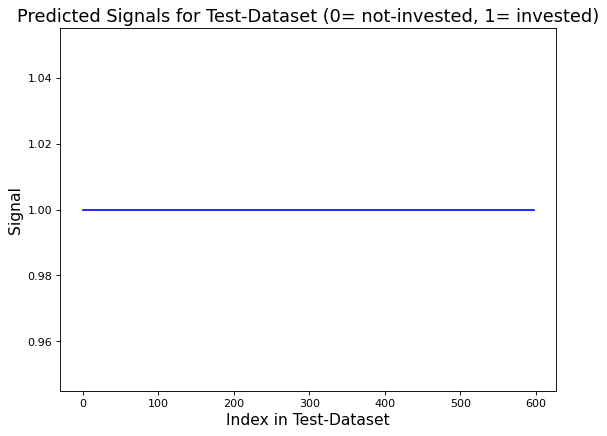

In [127]:
which = 0

parameters = {'axes.labelsize': 14,
          'axes.titlesize': 16}
plt.rcParams.update(parameters)

plt.figure(figsize=(8, 6), dpi=80)
plt.plot(pred_binary, 'b', label='Buy - Sell')
plt.title("Predicted Signals for Test-Dataset (0= not-invested, 1= invested)")
plt.xlabel("Index in Test-Dataset")
plt.ylabel('Signal')

plt.show()

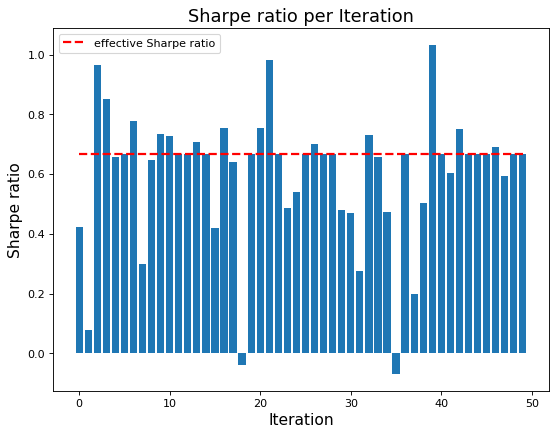

In [121]:
plt.figure(figsize=(8, 6), dpi=80)
plt.bar(range(loops), np.transpose(sharpe_ratio_hist)[0])
plt.title("Sharpe ratio per Iteration")
plt.xlabel("Iteration")
plt.ylabel('Sharpe ratio')
plt.plot([0, loops-1], [eff_sharpe_nn, eff_sharpe_nn],color='red',
         linestyle='dashed',linewidth=2, label = 'effective Sharpe ratio') 
plt.legend()

plt.show()

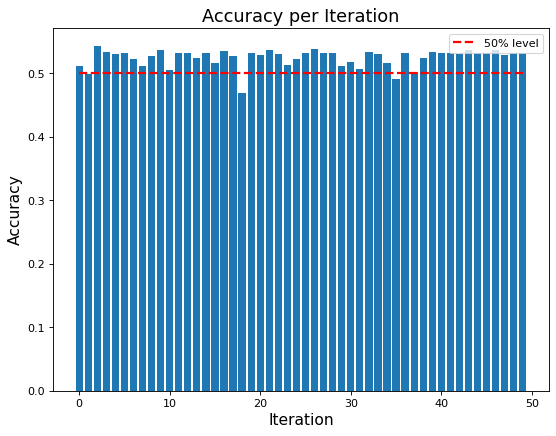

In [122]:
plt.figure(figsize=(8, 6), dpi=80)
plt.bar(range(loops), out_samp_accuracy)
plt.title("Accuracy per Iteration")
plt.xlabel("Iteration")
plt.ylabel('Accuracy')
plt.plot([0, loops-1], [0.5, 0.5],color='red',
         linestyle='dashed',linewidth=2, label = '50% level') 
plt.legend()
plt.show()

## Combined results

In [123]:
results =  pd.DataFrame()

results['out_sample_cumsum'] = average_cumsum #average log cumsum performance on Test_dataset
results['eff_cumsum'] = eff_cumsum[len(eff_cumsum)-1:] #effective log cumsum perfomance
results['out_sample_accuracy'] = average_accuracy # average out of sample accuracy based on Test_dataset
results['in_sample_accuracy'] = sum(in_samp_acc)/len(in_samp_acc) # average in sample accuracybased on Train_datset
results['average_sharpe_ratio'] = float(sum(sharpe_ratio_hist)/len(sharpe_ratio_hist)) #averate sharpe ratio
results['buy_hold_sharpe_ratio'] = float(eff_sharpe_nn) #effective sharpe ratio with buy and hold
results['eff_perc_pos_returns'] = eff_perc_pos_returns #effecitve percentage of days with positive returns
results['1s_predicted'] = np.round(sum(sum_pred_binary_hist)/len(sum_pred_binary_hist)) # average 1s predicted
results['in_sample_Loss (Train)'] = sum(in_samp_loss)/len(in_samp_loss)  # average train loss of last iteration of test dataset
results['out_sample_Loss (Validation)'] = sum(out_samp_loss)/len(out_samp_loss) #average validation loss of last iteration of validation dataset
results['loops'] = loops
results['train_lvl'] = train_lvl
results['train_size'] = len(y_train)
results['test_size'] = len(y_test)

print("Input Features")
print(list(column_names[1:]))
results

Input Features
['rNorm']


,out_sample_cumsum,eff_cumsum,out_sample_accuracy,in_sample_accuracy,average_sharpe_ratio,buy_hold_sharpe_ratio,eff_perc_pos_returns,1s_predicted,in_sample_Loss (Train),out_sample_Loss (Validation),loops,train_lvl,train_size,test_size
1494,0.921821,1.054334,0.524682,0.54903,0.602818,0.665636,0.531773,534.0,0.687444,0.697651,50,0.6,897,598


In [124]:
# 95% confindence interval for mean out-of-sample accuracy (only with multiple loops possible)

import scipy.stats as st

#define sample data
dat = out_samp_accuracy

#create 95% confidence interval for mean accuracy
confint = st.t.interval(alpha=0.95, df=len(dat)-1, loc=np.mean(dat), scale=st.sem(dat)) 
print("95% confidence interval for accuracy : ", confint)

95% confidence interval for accuracy :  (0.5207438697232731, 0.5286206787717103)


# Plots comparing the 6 sets (50 loops)

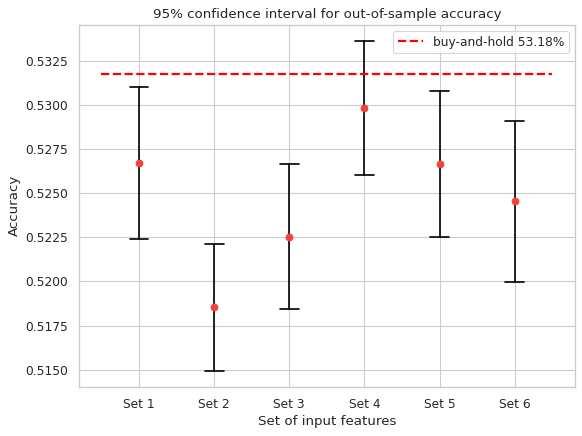

In [ ]:
import statistics
from math import sqrt


set_1 = [0.5367892976588629, 0.520066889632107, 0.5183946488294314, 0.540133779264214, 0.5217391304347826, 0.5384615384615384, 0.520066889632107, 0.5451505016722408, 0.5267558528428093, 0.48494983277591974, 0.5250836120401338, 0.5418060200668896, 0.5267558528428093, 0.4882943143812709, 0.4983277591973244, 0.5384615384615384, 0.5301003344481605, 0.5301003344481605, 0.5451505016722408, 0.48327759197324416, 0.5217391304347826, 0.5451505016722408, 0.5250836120401338, 0.5317725752508361, 0.5301003344481605, 0.5183946488294314, 0.4983277591973244, 0.5317725752508361, 0.5083612040133779, 0.520066889632107, 0.5267558528428093, 0.5434782608695652, 0.5351170568561873, 0.5267558528428093, 0.5367892976588629, 0.5234113712374582, 0.5484949832775919, 0.5033444816053512, 0.5301003344481605, 0.520066889632107, 0.540133779264214, 0.5367892976588629, 0.5301003344481605, 0.5317725752508361, 0.5418060200668896, 0.540133779264214, 0.540133779264214, 0.5317725752508361, 0.5301003344481605, 0.5284280936454849]
set_2 = [0.5317725752508361, 0.5267558528428093, 0.5217391304347826, 0.5066889632107023, 0.5, 0.520066889632107, 0.5267558528428093, 0.5250836120401338, 0.5317725752508361, 0.5234113712374582, 0.5234113712374582, 0.5217391304347826, 0.4983277591973244, 0.5217391304347826, 0.5301003344481605, 0.5267558528428093, 0.5267558528428093, 0.49498327759197325, 0.5384615384615384, 0.5133779264214047, 0.5434782608695652, 0.5033444816053512, 0.5167224080267558, 0.5183946488294314, 0.5217391304347826, 0.520066889632107, 0.5150501672240803, 0.5016722408026756, 0.5367892976588629, 0.5284280936454849, 0.5384615384615384, 0.49498327759197325, 0.5117056856187291, 0.520066889632107, 0.5133779264214047, 0.5451505016722408, 0.5150501672240803, 0.520066889632107, 0.5234113712374582, 0.4899665551839465, 0.5351170568561873, 0.5100334448160535, 0.4983277591973244, 0.5100334448160535, 0.5117056856187291, 0.5033444816053512, 0.5167224080267558, 0.5117056856187291, 0.5267558528428093, 0.5150501672240803]
set_3 = [0.5183946488294314, 0.5083612040133779, 0.5150501672240803, 0.5100334448160535, 0.4899665551839465, 0.5351170568561873, 0.5284280936454849, 0.5066889632107023, 0.5301003344481605, 0.5334448160535117, 0.5066889632107023, 0.5284280936454849, 0.5033444816053512, 0.5351170568561873, 0.5234113712374582, 0.5384615384615384, 0.5284280936454849, 0.5183946488294314, 0.5367892976588629, 0.5384615384615384, 0.5351170568561873, 0.5167224080267558, 0.5117056856187291, 0.520066889632107, 0.5351170568561873, 0.4816053511705686, 0.5317725752508361, 0.5250836120401338, 0.5217391304347826, 0.5234113712374582, 0.5167224080267558, 0.5334448160535117, 0.5484949832775919, 0.5267558528428093, 0.5133779264214047, 0.5301003344481605, 0.49498327759197325, 0.5434782608695652, 0.5133779264214047, 0.5351170568561873, 0.5351170568561873, 0.4983277591973244, 0.5334448160535117, 0.5468227424749164, 0.5150501672240803, 0.5150501672240803, 0.5418060200668896, 0.5083612040133779, 0.5301003344481605, 0.5117056856187291]
set_4 = [0.5133779264214047, 0.5217391304347826, 0.5501672240802675, 0.5334448160535117, 0.5183946488294314, 0.5434782608695652, 0.5652173913043478, 0.5317725752508361, 0.5083612040133779, 0.5451505016722408, 0.5367892976588629, 0.520066889632107, 0.5351170568561873, 0.520066889632107, 0.5351170568561873, 0.5234113712374582, 0.520066889632107, 0.5117056856187291, 0.5284280936454849, 0.5250836120401338, 0.5217391304347826, 0.5117056856187291, 0.5484949832775919, 0.5367892976588629, 0.5468227424749164, 0.5250836120401338, 0.5167224080267558, 0.5468227424749164, 0.5217391304347826, 0.5535117056856187, 0.5317725752508361, 0.4983277591973244, 0.5484949832775919, 0.5150501672240803, 0.5317725752508361, 0.5535117056856187, 0.5451505016722408, 0.5217391304347826, 0.5183946488294314, 0.5334448160535117, 0.5301003344481605, 0.5167224080267558, 0.5317725752508361, 0.5418060200668896, 0.5317725752508361, 0.5183946488294314, 0.520066889632107, 0.5301003344481605, 0.5301003344481605, 0.5267558528428093]
set_5 = [0.5033444816053512, 0.5451505016722408, 0.5217391304347826, 0.5250836120401338, 0.5384615384615384, 0.520066889632107, 0.4916387959866221, 0.5183946488294314, 0.5234113712374582, 0.540133779264214, 0.5016722408026756, 0.5301003344481605, 0.5234113712374582, 0.5367892976588629, 0.5351170568561873, 0.5217391304347826, 0.49665551839464883, 0.5167224080267558, 0.5384615384615384, 0.5267558528428093, 0.5367892976588629, 0.5367892976588629, 0.5334448160535117, 0.5284280936454849, 0.5150501672240803, 0.5351170568561873, 0.5418060200668896, 0.5100334448160535, 0.520066889632107, 0.5284280936454849, 0.5351170568561873, 0.540133779264214, 0.5284280936454849, 0.5016722408026756, 0.5083612040133779, 0.5451505016722408, 0.5434782608695652, 0.5267558528428093, 0.5117056856187291, 0.5518394648829431, 0.5484949832775919, 0.5150501672240803, 0.5267558528428093, 0.5585284280936454, 0.5351170568561873, 0.5117056856187291, 0.5484949832775919, 0.5150501672240803, 0.5117056856187291, 0.5284280936454849]
set_6 = [0.5468227424749164, 0.5635451505016722, 0.540133779264214, 0.5033444816053512, 0.5334448160535117, 0.520066889632107, 0.5066889632107023, 0.5, 0.5351170568561873, 0.5484949832775919, 0.5133779264214047, 0.5317725752508361, 0.5384615384615384, 0.520066889632107, 0.5050167224080268, 0.5418060200668896, 0.520066889632107, 0.5384615384615384, 0.5267558528428093, 0.5351170568561873, 0.5250836120401338, 0.5451505016722408, 0.5468227424749164, 0.5066889632107023, 0.5351170568561873, 0.5217391304347826, 0.5033444816053512, 0.5351170568561873, 0.5016722408026756, 0.5133779264214047, 0.5484949832775919, 0.5016722408026756, 0.5167224080267558, 0.5016722408026756, 0.5150501672240803, 0.5317725752508361, 0.5267558528428093, 0.5150501672240803, 0.540133779264214, 0.5167224080267558, 0.5117056856187291, 0.5250836120401338, 0.5484949832775919, 0.5234113712374582, 0.5351170568561873, 0.5066889632107023, 0.49331103678929766, 0.5384615384615384, 0.5217391304347826, 0.5066889632107023]

# https://stackoverflow.com/questions/59747313/how-to-plot-confidence-interval-in-python

def plot_confidence_interval(x, values, z=1.96, color='black', horizontal_line_width=0.25):
    mean = statistics.mean(values)
    stdev = statistics.stdev(values)
    confidence_interval = z * stdev / sqrt(len(values))

    left = x - horizontal_line_width / 2
    top = mean - confidence_interval
    right = x + horizontal_line_width / 2
    bottom = mean + confidence_interval
    plt.plot([x, x], [top, bottom], color=color)
    plt.plot([left, right], [top, top], color=color)
    plt.plot([left, right], [bottom, bottom], color=color)
    plt.plot(x, mean, 'o', color='#f44336')
    plt.xlabel("Set of input features")
    plt.ylabel('Accuracy')

    return mean, confidence_interval

sns.set(style="whitegrid")

plt.figure(figsize=(8, 6), dpi=80)
plt.xticks([1, 2, 3, 4, 5, 6], ['Set 1', 'Set 2', 'Set 3', 'Set 4', 'Set 5', 'Set 6'])
#plt.xticks([1], ['Accuracy'])
plt.title('95% confidence interval for out-of-sample accuracy')
#plot_confidence_interval(1, out_samp_accuracy)
plot_confidence_interval(1, set_1)
plot_confidence_interval(2, set_2)
plot_confidence_interval(3, set_3)
plot_confidence_interval(4, set_4)
plot_confidence_interval(5, set_5)
plot_confidence_interval(6, set_6)
#plot_confidence_interval(4, [30, 31, 42, 45, 44])

buy_hold_acc = np.sum(y_test)[0]/len(y_test)
plt.plot([0.5, 6.5], [buy_hold_acc, buy_hold_acc],color='red',
         linestyle='dashed',linewidth=2, label = 'buy-and-hold 53.18%') 
plt.legend()

plt.show()

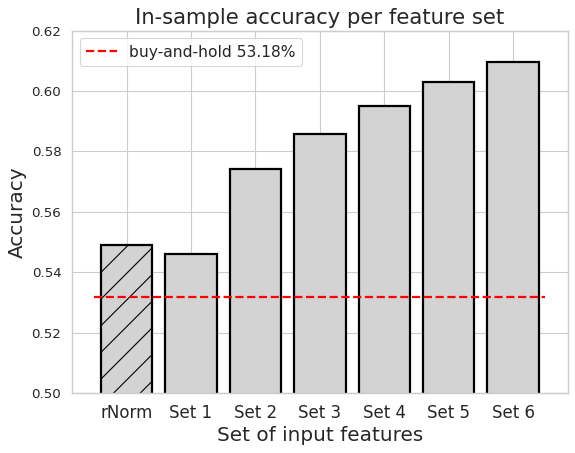

In [20]:
# in-sample accuracy per set

height = [0.549, 0.5460, 0.5742, 0.5856, 0.595, 0.603, 0.6095]

bars = ('rNorm', 'Set 1', 'Set 2', 'Set 3', 'Set 4', 'Set 5', 'Set 6')
y_pos = np.arange(len(bars))


sns.set(style="whitegrid")
parameters = {'axes.labelsize': 18,
          'axes.titlesize': 19}
plt.rcParams.update(parameters)


# Create bars
plt.figure(figsize=(8, 6), dpi=80)
bars = plt.bar(y_pos, height, color='lightgray', edgecolor='black', linewidth=2)
plt.ylim(0.50, 0.62)
plt.title("In-sample accuracy per feature set")
plt.xlabel("Set of input features")
plt.ylabel('Accuracy')
plt.xticks([0, 1, 2, 3, 4, 5, 6], ['rNorm', 'Set 1', 'Set 2', 'Set 3', 'Set 4', 'Set 5', 'Set 6'], fontsize=15)
plt.yticks(fontsize = 12)



bars[0].set(hatch = '/', fill=True)

buy_hold_acc = np.sum(y_test)[0]/len(y_test)
plt.plot([-0.5, len(height)-0.5], [buy_hold_acc, buy_hold_acc],color='red',
         linestyle='dashed',linewidth=2, label = 'buy-and-hold 53.18%') 
plt.legend(loc ='upper left', fontsize = 14)
plt.show()

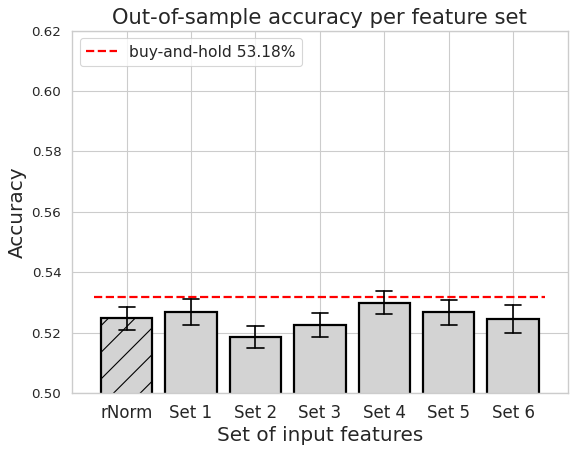

In [21]:
# out-of-sample accuracy per set with confint

import seaborn as sns
import statistics
from math import sqrt

sns.set(style="whitegrid")
parameters = {'axes.labelsize': 18,
          'axes.titlesize': 19}
plt.rcParams.update(parameters)


buy_hold_acc = np.sum(y_test)[0]/len(y_test)

height = [0.5247, 0.5267, 0.5185, 0.5225, 0.5298, 0.5267, 0.5245]

bars = ('rNorm', 'Set 1', 'Set 2', 'Set 3', 'Set 4', 'Set 5', 'Set 6')
y_pos = np.arange(len(bars))

# Create bars
plt.figure(figsize=(8, 6), dpi=80)
bars = plt.bar(y_pos, height, color='lightgray', edgecolor='black', linewidth=2)
plt.ylim(0.50, 0.62)
plt.title("Out-of-sample accuracy per feature set")
plt.xlabel("Set of input features")
plt.ylabel('Accuracy')
plt.xticks([0, 1, 2, 3, 4, 5, 6], ['rNorm','Set 1', 'Set 2', 'Set 3', 'Set 4', 'Set 5', 'Set 6'], fontsize = 15)
plt.yticks(fontsize = 12)



#plt.plot([-0.5, len(height)-0.5], [0.5, 0.5],color='black',
         #linestyle='dashed',linewidth=2, label = '50% level') 

plt.plot([-0.5, len(height)-0.5], [buy_hold_acc, buy_hold_acc],color='red',
         linestyle='dashed',linewidth=2, label = 'buy-and-hold 53.18%') 

rNorm = [0.5117056856187291, 0.4983277591973244, 0.5434782608695652, 0.5334448160535117, 0.5301003344481605, 0.5317725752508361, 0.5217391304347826, 0.5117056856187291, 0.5267558528428093, 0.5367892976588629, 0.5050167224080268, 0.5317725752508361, 0.5317725752508361, 0.5234113712374582, 0.5317725752508361, 0.5167224080267558, 0.5351170568561873, 0.5267558528428093, 0.4682274247491639, 0.5317725752508361, 0.5284280936454849, 0.5367892976588629, 0.5301003344481605, 0.5133779264214047, 0.5217391304347826, 0.5317725752508361, 0.5384615384615384, 0.5317725752508361, 0.5317725752508361, 0.5117056856187291, 0.5183946488294314, 0.5066889632107023, 0.5334448160535117, 0.5301003344481605, 0.5167224080267558, 0.4916387959866221, 0.5317725752508361, 0.5016722408026756, 0.5234113712374582, 0.5334448160535117, 0.5317725752508361, 0.5317725752508361, 0.5301003344481605, 0.5367892976588629, 0.5317725752508361, 0.5317725752508361, 0.5367892976588629, 0.5284280936454849, 0.5317725752508361, 0.5317725752508361]
set_1 = [0.5367892976588629, 0.520066889632107, 0.5183946488294314, 0.540133779264214, 0.5217391304347826, 0.5384615384615384, 0.520066889632107, 0.5451505016722408, 0.5267558528428093, 0.48494983277591974, 0.5250836120401338, 0.5418060200668896, 0.5267558528428093, 0.4882943143812709, 0.4983277591973244, 0.5384615384615384, 0.5301003344481605, 0.5301003344481605, 0.5451505016722408, 0.48327759197324416, 0.5217391304347826, 0.5451505016722408, 0.5250836120401338, 0.5317725752508361, 0.5301003344481605, 0.5183946488294314, 0.4983277591973244, 0.5317725752508361, 0.5083612040133779, 0.520066889632107, 0.5267558528428093, 0.5434782608695652, 0.5351170568561873, 0.5267558528428093, 0.5367892976588629, 0.5234113712374582, 0.5484949832775919, 0.5033444816053512, 0.5301003344481605, 0.520066889632107, 0.540133779264214, 0.5367892976588629, 0.5301003344481605, 0.5317725752508361, 0.5418060200668896, 0.540133779264214, 0.540133779264214, 0.5317725752508361, 0.5301003344481605, 0.5284280936454849]
set_2 = [0.5317725752508361, 0.5267558528428093, 0.5217391304347826, 0.5066889632107023, 0.5, 0.520066889632107, 0.5267558528428093, 0.5250836120401338, 0.5317725752508361, 0.5234113712374582, 0.5234113712374582, 0.5217391304347826, 0.4983277591973244, 0.5217391304347826, 0.5301003344481605, 0.5267558528428093, 0.5267558528428093, 0.49498327759197325, 0.5384615384615384, 0.5133779264214047, 0.5434782608695652, 0.5033444816053512, 0.5167224080267558, 0.5183946488294314, 0.5217391304347826, 0.520066889632107, 0.5150501672240803, 0.5016722408026756, 0.5367892976588629, 0.5284280936454849, 0.5384615384615384, 0.49498327759197325, 0.5117056856187291, 0.520066889632107, 0.5133779264214047, 0.5451505016722408, 0.5150501672240803, 0.520066889632107, 0.5234113712374582, 0.4899665551839465, 0.5351170568561873, 0.5100334448160535, 0.4983277591973244, 0.5100334448160535, 0.5117056856187291, 0.5033444816053512, 0.5167224080267558, 0.5117056856187291, 0.5267558528428093, 0.5150501672240803]
set_3 = [0.5183946488294314, 0.5083612040133779, 0.5150501672240803, 0.5100334448160535, 0.4899665551839465, 0.5351170568561873, 0.5284280936454849, 0.5066889632107023, 0.5301003344481605, 0.5334448160535117, 0.5066889632107023, 0.5284280936454849, 0.5033444816053512, 0.5351170568561873, 0.5234113712374582, 0.5384615384615384, 0.5284280936454849, 0.5183946488294314, 0.5367892976588629, 0.5384615384615384, 0.5351170568561873, 0.5167224080267558, 0.5117056856187291, 0.520066889632107, 0.5351170568561873, 0.4816053511705686, 0.5317725752508361, 0.5250836120401338, 0.5217391304347826, 0.5234113712374582, 0.5167224080267558, 0.5334448160535117, 0.5484949832775919, 0.5267558528428093, 0.5133779264214047, 0.5301003344481605, 0.49498327759197325, 0.5434782608695652, 0.5133779264214047, 0.5351170568561873, 0.5351170568561873, 0.4983277591973244, 0.5334448160535117, 0.5468227424749164, 0.5150501672240803, 0.5150501672240803, 0.5418060200668896, 0.5083612040133779, 0.5301003344481605, 0.5117056856187291]
set_4 = [0.5133779264214047, 0.5217391304347826, 0.5501672240802675, 0.5334448160535117, 0.5183946488294314, 0.5434782608695652, 0.5652173913043478, 0.5317725752508361, 0.5083612040133779, 0.5451505016722408, 0.5367892976588629, 0.520066889632107, 0.5351170568561873, 0.520066889632107, 0.5351170568561873, 0.5234113712374582, 0.520066889632107, 0.5117056856187291, 0.5284280936454849, 0.5250836120401338, 0.5217391304347826, 0.5117056856187291, 0.5484949832775919, 0.5367892976588629, 0.5468227424749164, 0.5250836120401338, 0.5167224080267558, 0.5468227424749164, 0.5217391304347826, 0.5535117056856187, 0.5317725752508361, 0.4983277591973244, 0.5484949832775919, 0.5150501672240803, 0.5317725752508361, 0.5535117056856187, 0.5451505016722408, 0.5217391304347826, 0.5183946488294314, 0.5334448160535117, 0.5301003344481605, 0.5167224080267558, 0.5317725752508361, 0.5418060200668896, 0.5317725752508361, 0.5183946488294314, 0.520066889632107, 0.5301003344481605, 0.5301003344481605, 0.5267558528428093]
set_5 = [0.5033444816053512, 0.5451505016722408, 0.5217391304347826, 0.5250836120401338, 0.5384615384615384, 0.520066889632107, 0.4916387959866221, 0.5183946488294314, 0.5234113712374582, 0.540133779264214, 0.5016722408026756, 0.5301003344481605, 0.5234113712374582, 0.5367892976588629, 0.5351170568561873, 0.5217391304347826, 0.49665551839464883, 0.5167224080267558, 0.5384615384615384, 0.5267558528428093, 0.5367892976588629, 0.5367892976588629, 0.5334448160535117, 0.5284280936454849, 0.5150501672240803, 0.5351170568561873, 0.5418060200668896, 0.5100334448160535, 0.520066889632107, 0.5284280936454849, 0.5351170568561873, 0.540133779264214, 0.5284280936454849, 0.5016722408026756, 0.5083612040133779, 0.5451505016722408, 0.5434782608695652, 0.5267558528428093, 0.5117056856187291, 0.5518394648829431, 0.5484949832775919, 0.5150501672240803, 0.5267558528428093, 0.5585284280936454, 0.5351170568561873, 0.5117056856187291, 0.5484949832775919, 0.5150501672240803, 0.5117056856187291, 0.5284280936454849]
set_6 = [0.5468227424749164, 0.5635451505016722, 0.540133779264214, 0.5033444816053512, 0.5334448160535117, 0.520066889632107, 0.5066889632107023, 0.5, 0.5351170568561873, 0.5484949832775919, 0.5133779264214047, 0.5317725752508361, 0.5384615384615384, 0.520066889632107, 0.5050167224080268, 0.5418060200668896, 0.520066889632107, 0.5384615384615384, 0.5267558528428093, 0.5351170568561873, 0.5250836120401338, 0.5451505016722408, 0.5468227424749164, 0.5066889632107023, 0.5351170568561873, 0.5217391304347826, 0.5033444816053512, 0.5351170568561873, 0.5016722408026756, 0.5133779264214047, 0.5484949832775919, 0.5016722408026756, 0.5167224080267558, 0.5016722408026756, 0.5150501672240803, 0.5317725752508361, 0.5267558528428093, 0.5150501672240803, 0.540133779264214, 0.5167224080267558, 0.5117056856187291, 0.5250836120401338, 0.5484949832775919, 0.5234113712374582, 0.5351170568561873, 0.5066889632107023, 0.49331103678929766, 0.5384615384615384, 0.5217391304347826, 0.5066889632107023]

# https://stackoverflow.com/questions/59747313/how-to-plot-confidence-interval-in-python

def plot_confidence_interval(x, values, z=1.96, color='black', horizontal_line_width=0.25):
    mean = statistics.mean(values)
    stdev = statistics.stdev(values)
    confidence_interval = z * stdev / sqrt(len(values))

    left = x - horizontal_line_width / 2
    top = mean - confidence_interval
    right = x + horizontal_line_width / 2
    bottom = mean + confidence_interval
    plt.plot([x, x], [top, bottom], color=color)
    plt.plot([left, right], [top, top], color=color)
    plt.plot([left, right], [bottom, bottom], color=color)
    #plt.plot(x, mean, 'o', color='#f44336')
    plt.xlabel("Set of input features")
    plt.ylabel('Accuracy')

    return mean, confidence_interval

plot_confidence_interval(0, rNorm)
plot_confidence_interval(1, set_1)
plot_confidence_interval(2, set_2)
plot_confidence_interval(3, set_3)
plot_confidence_interval(4, set_4)
plot_confidence_interval(5, set_5)
plot_confidence_interval(6, set_6)

bars[0].set(hatch = '/', fill=True)

plt.legend(loc ='upper left', fontsize = 14)

plt.show()

No handles with labels found to put in legend.


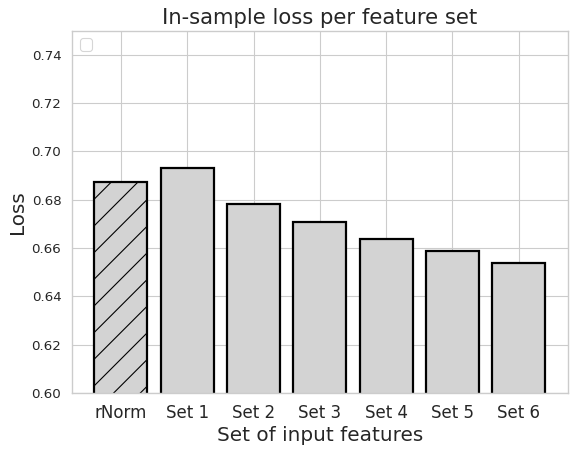

In [22]:
# in-sample loss per set

height = [0.6874, 0.6931, 0.6781, 0.6707, 0.6637, 0.6586, 0.6539]

bars = ('rNorm', 'Set 1', 'Set 2', 'Set 3', 'Set 4', 'Set 5', 'Set 6')
y_pos = np.arange(len(bars))

sns.set(style="whitegrid")
parameters = {'axes.labelsize': 18,
          'axes.titlesize': 19}
plt.rcParams.update(parameters)


# Create bars
plt.figure(figsize=(8, 6), dpi=80)
bars = plt.bar(y_pos, height, color='lightgray', edgecolor='black', linewidth=2)
plt.ylim(0.6, 0.75)
plt.title("In-sample loss per feature set")
plt.xlabel("Set of input features")
plt.ylabel('Loss')
plt.xticks([0, 1, 2, 3, 4, 5, 6], ['rNorm', 'Set 1', 'Set 2', 'Set 3', 'Set 4', 'Set 5', 'Set 6'], fontsize = 15)
plt.yticks(fontsize = 12)

bars[0].set(hatch = '/', fill=True)

plt.legend(loc ='upper left', fontsize = 14)
plt.show()


No handles with labels found to put in legend.


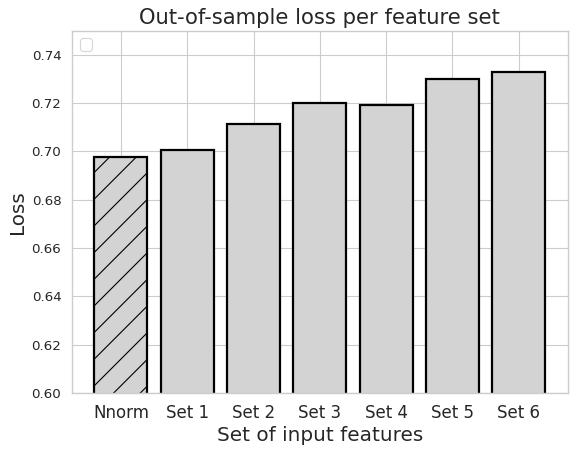

In [23]:
# out-of-sample loss per set

height = [0.6977, 0.7007, 0.7115, 0.7201, 0.7191, 0.7298, 0.7328]

bars = ('rNorm', 'Set 1', 'Set 2', 'Set 3', 'Set 4', 'Set 5', 'Set 6')
y_pos = np.arange(len(bars))


sns.set(style="whitegrid")
parameters = {'axes.labelsize': 18,
          'axes.titlesize': 19}
plt.rcParams.update(parameters)

# Create bars
plt.figure(figsize=(8, 6), dpi=80)
bars = plt.bar(y_pos, height, color='lightgray', edgecolor='black', linewidth=2)
plt.ylim(0.6, 0.75)
plt.title("Out-of-sample loss per feature set")
plt.xlabel("Set of input features")
plt.ylabel('Loss')
plt.xticks([0, 1, 2, 3, 4, 5, 6], ['Nnorm', 'Set 1', 'Set 2', 'Set 3', 'Set 4', 'Set 5', 'Set 6'], fontsize = 15)
plt.yticks(fontsize = 12)

bars[0].set(hatch = '/', fill=True)

plt.legend(loc ='upper left', fontsize = 14)
plt.show()

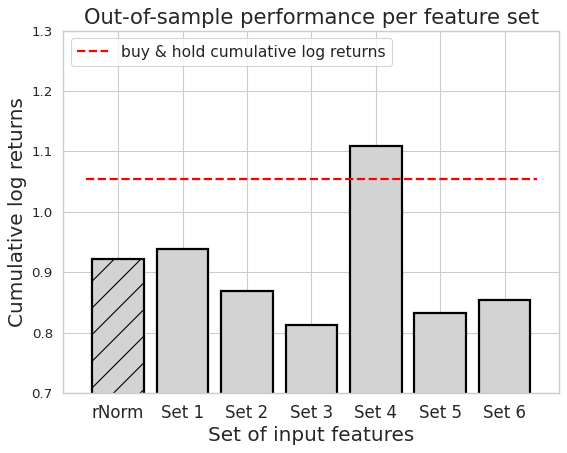

In [24]:
# out-of-sample performance per set

height = [0.9218, 0.9382, 0.8697, 0.8118, 1.1089, 0.8325, 0.8532]

bars = ('rNorm', 'Set 1', 'Set 2', 'Set 3', 'Set 4', 'Set 5', 'Set 6')

sns.set(style="whitegrid")
parameters = {'axes.labelsize': 18,
          'axes.titlesize': 19}
plt.rcParams.update(parameters)

# Create bars
plt.figure(figsize=(8, 6), dpi=80)
bars = plt.bar(y_pos, height, color='lightgray', edgecolor='black', linewidth=2)
plt.ylim(0.7, 1.3)
plt.title("Out-of-sample performance per feature set")
plt.xlabel("Set of input features")
plt.ylabel('Cumulative log returns')
plt.xticks([0, 1, 2, 3, 4, 5, 6], ['rNorm', 'Set 1', 'Set 2', 'Set 3', 'Set 4', 'Set 5', 'Set 6'], fontsize = 15)
plt.yticks(fontsize = 12)

plt.plot([-0.5, len(height)-0.5], [1.0543, 1.0543],color='red',
         linestyle='dashed',linewidth=2, label = 'buy & hold cumulative log returns') 

bars[0].set(hatch = '/', fill=True)

plt.legend(loc ='upper left', fontsize = 14)
plt.show()

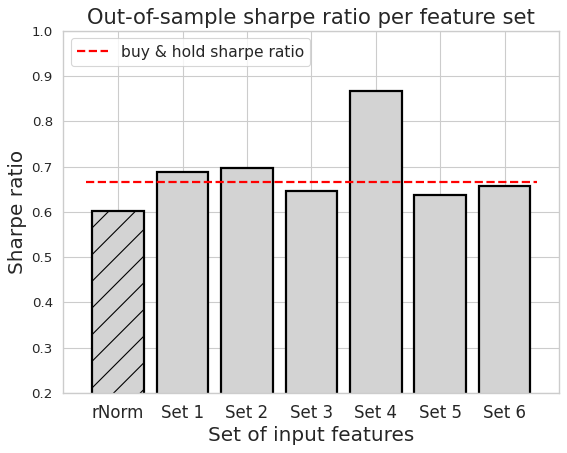

In [26]:
# out-of-sample sharpe ratio per set

height = [0.6028, 0.687, 0.696, 0.646, 0.866, 0.637, 0.656]

bars = ('rNorm', 'Set 1', 'Set 2', 'Set 3', 'Set 4', 'Set 5', 'Set 6')
y_pos = np.arange(len(bars))

sns.set(style="whitegrid")
parameters = {'axes.labelsize': 18,
          'axes.titlesize': 19}
plt.rcParams.update(parameters)

# Create bars
plt.figure(figsize=(8, 6), dpi=80)
bars = plt.bar(y_pos, height, color='lightgray', edgecolor='black', linewidth=2)
plt.ylim(0.2, 1)
plt.title("Out-of-sample sharpe ratio per feature set")
plt.xlabel("Set of input features")
plt.ylabel('Sharpe ratio')
plt.xticks([0, 1, 2, 3, 4, 5, 6], ['rNorm', 'Set 1', 'Set 2', 'Set 3', 'Set 4', 'Set 5', 'Set 6'], fontsize = 15)
plt.yticks(fontsize = 12)

plt.plot([-0.5, len(height)-0.5], [0.6656, 0.6656],color='red',
         linestyle='dashed',linewidth=2, label = 'buy & hold sharpe ratio') 
bars[0].set(hatch = '/', fill=True)

plt.legend(loc ='upper left', fontsize = 14)
plt.show()

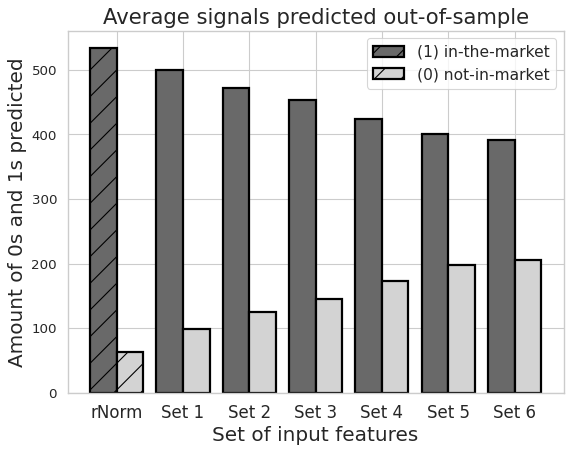

In [30]:
# out-of-sample signals per set

effective_ones = np.sum(y_test) # effective amount of positive log returns in test sample
test_size = len(y_test)
sets = ['rNorm', 'Set 1', 'Set 2', 'Set 3', 'Set 4', 'Set 5', 'Set 6']
ones = [534, 499, 472, 453, 424, 400, 392]
zeros = [64, 99, 126, 145, 174, 198, 206]

plt.figure(figsize=(8, 6), dpi=80)
x_axis = np.arange(len(sets))

sns.set(style="whitegrid")
parameters = {'axes.labelsize': 18,
          'axes.titlesize': 19}
plt.rcParams.update(parameters)

# Multi bar Chart

bars1 = plt.bar(x_axis -0.2, ones, width=0.4, label = '(1) in-the-market', color='dimgray', edgecolor='black', linewidth=2)  # plt.bar(y_pos, height, color='lightgray', edgecolor='black', linewidth=2)
bars2 = plt.bar(x_axis +0.2, zeros, width=0.4, label = '(0) not-in-market', color='lightgray', edgecolor='black', linewidth=2)

plt.title("Average signals predicted out-of-sample")
plt.xlabel("Set of input features")
plt.ylabel('Amount of 0s and 1s predicted')

bars1[0].set(hatch = '/', fill=True)
bars2[0].set(hatch = '/', fill=True)

plt.xticks(x_axis, sets , fontsize = 15)
plt.yticks(fontsize = 12)
plt.legend(fontsize = 14)
plt.show()

# Plots for bachelor thesis

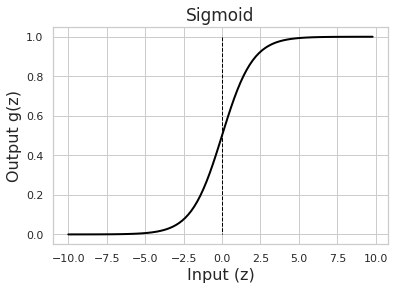

In [ ]:
# Sigmoid

import math
parameters = {'axes.labelsize': 16,
          'axes.titlesize': 17}
plt.rcParams.update(parameters)

def sigmoid(x):
    a = []
    for item in x:
        a.append(1/(1+math.exp(-item)))
    return a

import matplotlib.pyplot as plt
import numpy as np

x = np.arange(-10., 10., 0.2)
sig = sigmoid(x)
plt.plot([0, 0], [1, 0],color='black',
         linestyle='dashed',linewidth=1) 
plt.plot(x,sig, color = 'black', linewidth=2)
plt.title('Sigmoid')
plt.xlabel("Input (z)")
plt.ylabel('Output g(z)')
plt.grid()
plt.grid()
# Rplt.show()

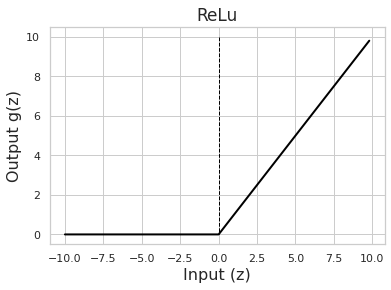

In [ ]:
# ReLu

def RELU(x):
    ''' It returns zero if the input is less than zero otherwise it returns the given input. '''
    x1=[]
    for i in x:
        if i<0:
            x1.append(0)
        else:
            x1.append(i)

    return x1

parameters = {'axes.labelsize': 16,
          'axes.titlesize': 17}
plt.rcParams.update(parameters)

import matplotlib.pyplot as plt
import numpy as np

plt.plot([0, 0], [10, 0],color='black',
         linestyle='dashed',linewidth=1) 

x = np.arange(-10., 10., 0.2)
relu = RELU(x)
plt.plot(x,relu, color = 'black', linewidth=2)
plt.title('ReLu')
plt.xlabel("Input (z)")
plt.ylabel('Output g(z)')
plt.grid()
plt.grid()
# Rplt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


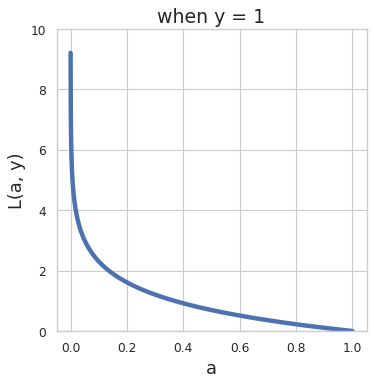

In [ ]:
# loss function Binary CrossEntropy (y = 1)

parameters = {'axes.labelsize': 16,
          'axes.titlesize': 17}
plt.rcParams.update(parameters)

def CrossEntropy(yHat, y):
    if y == 1:
      return -np.log(yHat)
    else:
      return -np.log(1 - yHat)

      import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(5, 5), dpi=80)
x = np.arange(0, 1, 0.0001)
plt.ylim(0, 10)
plt.xlim(-0.05, 1.05)
cross = CrossEntropy(x, 1)
plt.plot(x,cross,linewidth=4.0)
plt.title('when y = 1')
plt.xlabel("a")
plt.ylabel('L(a, y)')
plt.grid()
plt.grid()
# Rplt.show()

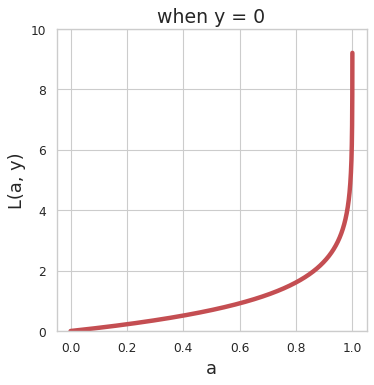

In [ ]:
# loss function Binary CrossEntropy (y = 0)

parameters = {'axes.labelsize': 16,
          'axes.titlesize': 17}
plt.rcParams.update(parameters)

def CrossEntropy(yHat, y):
    if y == 1:
      return -np.log(yHat)
    else:
      return -np.log(1 - yHat)
      
plt.figure(figsize=(5, 5), dpi=80)
x = np.arange(0, 1, 0.0001)
plt.ylim(0, 10)
plt.xlim(-0.05, 1.05)
cross = CrossEntropy(x, 0)
plt.plot(x,cross,linewidth=4.0, color = 'r')
plt.title('when y = 0')
plt.xlabel("a")
plt.ylabel('L(a, y)')
plt.grid()
plt.grid()
# Rplt.show()

In [ ]:
# example of y (target) and x (features) dataset rounded
datasets = pd.DataFrame()
datasets
datasets["Bitcoin Signal"] = y_train
datasets["Bitcoin"] = x_train[0]
datasets["S&P500"] = x_train[1]
datasets["Russell2000"] = x_train[2]
datasets["EURUSD"] = x_train[3]
datasets["TrasuryYield"] = x_train[4]
datasets["GoldSilver"] = x_train[5]
datasets = datasets.round(decimals=3)
datasets

,Bitcoin Signal,Bitcoin,S&P500,Russell2000,EURUSD,TrasuryYield,GoldSilver
0,0,0.565,0.553,0.591,0.350,0.418,0.453
1,1,0.569,0.525,0.518,0.597,0.377,0.416
2,0,0.790,0.497,0.524,0.514,0.383,0.561
3,0,0.631,0.568,0.610,0.503,0.421,0.466
4,0,0.633,0.441,0.492,0.395,0.367,0.501
...,...,...,...,...,...,...,...
892,1,0.601,0.527,0.562,0.515,0.417,0.458
893,1,0.681,0.562,0.586,0.475,0.434,0.494
894,1,0.721,0.530,0.580,0.500,0.424,0.439
895,1,0.678,0.515,0.523,0.469,0.401,0.473


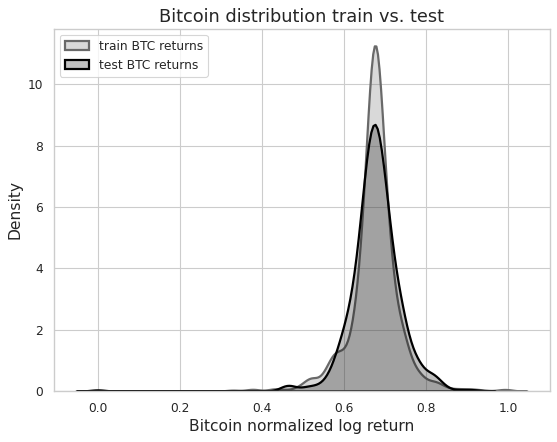

In [ ]:
plt.figure(figsize=(8, 6), dpi=80)

sns.set(style="whitegrid")
parameters = {'axes.labelsize': 14,
          'axes.titlesize': 16}
plt.rcParams.update(parameters)
 
# plotting both distibutions on the same figure
fig = sns.kdeplot(x_train[0], shade=True, label = 'train BTC returns', color='dimgray', edgecolor='dimgray', linewidth=2)
fig = sns.kdeplot(x_test[0], shade=True, label = 'test BTC returns', color='black', edgecolor='black', linewidth=2)

plt.title('Bitcoin distribution train vs. test')
plt.xlabel("Bitcoin normalized log return")
plt.ylabel('Density')
plt.legend(loc ='upper left')
plt.show()

In [ ]:
print("y_train positive: ", np.round((np.sum(y_train)/len(y_train))[0], 4))
print("y_test negative: " , np.round((np.sum(y_test)/len(y_test))[0], 4))

y_train positive:  0.5596
y_test negative:  0.5318


# Analysis of features (with plots)

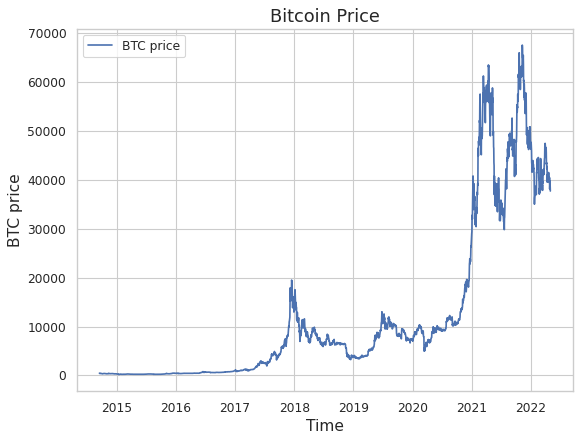

In [ ]:
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(prices['BTCUSD Close'], 'b', label='BTC price')
plt.xlabel("Time")
plt.ylabel('BTC price')
plt.title("Bitcoin Price")
plt.legend()


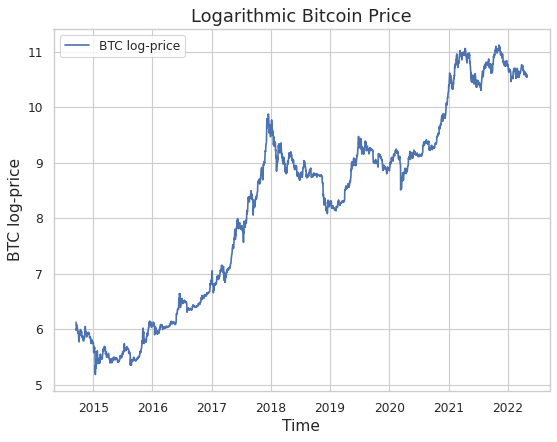

In [ ]:
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(log_prices['BTCUSD Close'], 'b', label='BTC log-price')
plt.xlabel("Time")
plt.ylabel('BTC log-price')
plt.title("Logarithmic Bitcoin Price")
plt.legend()

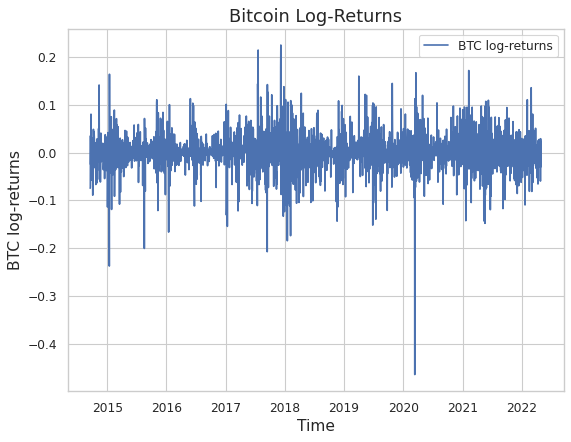

In [ ]:
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(log_returns['BTCUSD Close'], 'b', label='BTC log-returns')
plt.xlabel("Time")
plt.ylabel('BTC log-returns')
plt.title("Bitcoin Log-Returns")
plt.legend()

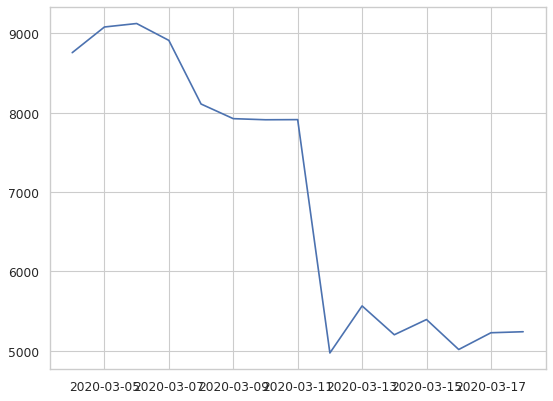

In [ ]:
# Biggest fall 2022-03-12

figure(figsize=(8, 6), dpi=80)

plt.plot(prices[1995:2010]['BTCUSD Close'])

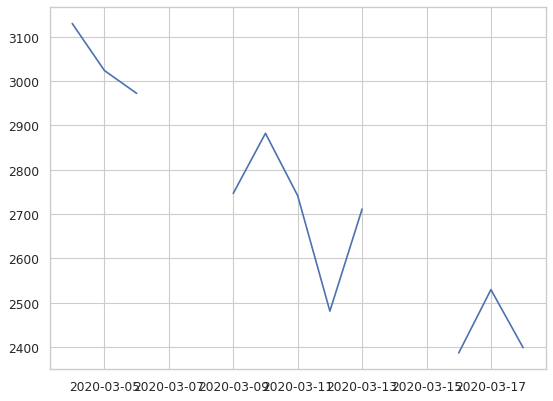

In [ ]:
# Biggest fall 2022-03-12

figure(figsize=(8, 6), dpi=80)

plt.plot(prices[1995:2010]['SP500'])

In [ ]:
# Biggest fall 2022-03-12

log_returns[1995:2006]

,BTCUSD Close,BTCUSD Volume,SP500,DAX,SP500FutJune20,Russell 2000,VIX CBOE,ETHUSD,Oil,Gold,Gold/Silver Index,UsTreasuryBond,EURUSD
Date,,,,,,,,,,,,,
2020-03-04,-0.003710,-0.198750,0.041336,0.024760,0.038537,0.029910,-0.140618,0.000171,-0.008514,-0.000609,0.011757,-0.017983,0.003282
2020-03-05,0.036285,0.133217,-0.034511,-0.022451,-0.032383,-0.034807,0.213911,0.020937,-0.018991,0.015299,0.019579,-0.068849,-0.003727
2020-03-06,0.004811,0.028039,-0.017201,-0.013370,-0.017226,-0.020219,0.056906,0.060328,-0.106087,0.002637,-0.016273,-0.271259,0.007581
2020-03-07,-0.023580,-0.119814,NaN,NaN,NaN,NaN,NaN,-0.023568,NaN,NaN,NaN,NaN,NaN
2020-03-08,-0.094304,0.098680,NaN,NaN,NaN,NaN,NaN,-0.169896,NaN,NaN,NaN,NaN,NaN
2020-03-09,-0.023014,0.160599,NaN,NaN,NaN,NaN,NaN,0.006443,NaN,NaN,NaN,NaN,NaN
2020-03-10,-0.001758,-0.106056,0.048215,0.026314,0.042048,0.028121,-0.140956,-0.006054,0.098721,-0.009239,0.012646,0.404797,0.001048
2020-03-11,0.000215,-0.087356,-0.050103,-0.049499,-0.044781,-0.066252,0.130620,-0.029821,-0.040992,-0.010726,-0.085442,0.091901,-0.007172
2020-03-12,-0.464730,0.333226,-0.099945,-0.120154,-0.104236,-0.118577,0.336605,-0.550732,-0.045914,-0.032256,-0.119695,0.034755,-0.004871


In [ ]:
prices[1995:2006]

,BTCUSD Close,BTCUSD Volume,SP500,DAX,SP500FutJune20,Russell 2000,VIX CBOE,ETHUSD,Oil,Gold,Gold/Silver Index,UsTreasuryBond,EURUSD
Date,,,,,,,,,,,,,
2020-03-04,8755.246094,34746706368,3130.120117,25.719999,3114.75,1531.199951,31.990000,224.517975,46.779999,1641.099976,102.669998,0.992,1.118068
2020-03-05,9078.762695,39698054597,3023.939941,25.149000,3015.50,1478.819946,39.619999,229.268188,45.900002,1666.400024,104.699997,0.926,1.113908
2020-03-06,9122.545898,40826885651,2972.370117,24.815001,2964.00,1449.219971,41.939999,243.525299,41.279999,1670.800049,103.010002,0.706,1.122385
2020-03-07,8909.954102,36216930370,NaN,NaN,NaN,NaN,NaN,237.853088,NaN,NaN,NaN,NaN,NaN
2020-03-08,8108.116211,39973102121,NaN,NaN,NaN,NaN,NaN,200.689056,NaN,NaN,NaN,NaN,NaN
2020-03-09,7923.644531,46936995808,2746.560059,22.690001,2747.75,1313.439941,54.459999,201.986328,31.129999,1674.500000,94.290001,0.499,1.138602
2020-03-10,7909.729492,42213940994,2882.229980,23.295000,2865.75,1350.900024,47.299999,200.767242,34.360001,1659.099976,95.489998,0.748,1.139796
2020-03-11,7911.430176,38682762605,2741.379883,22.170000,2740.25,1264.300049,53.900002,194.868530,32.980000,1641.400024,87.669998,0.820,1.131651
2020-03-12,4970.788086,53980357243,2480.639893,19.660000,2469.00,1122.930054,75.470001,112.347122,31.500000,1589.300049,77.779999,0.849,1.126152


In [ ]:
# BTC lost 37% on 2020-03-12
1-4970/7911

0.37176083933763115

In [ ]:
# calculate the Pearson's correlation between two variables
from scipy.stats import pearsonr

corr = pd.DataFrame()
corr['GC'] = prices['Gold']
corr['XAU'] = prices['Gold/Silver Index']

corr = corr.dropna()

corr


# calculate Pearson's correlation
corr, _ = pearsonr(corr['GC'], corr['XAU'])
print('Pearsons correlation of Gold future with XAU index: %.3f' % corr)


Pearsons correlation of Gold future with XAU index: 0.950


## Correlation Heat-Map

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


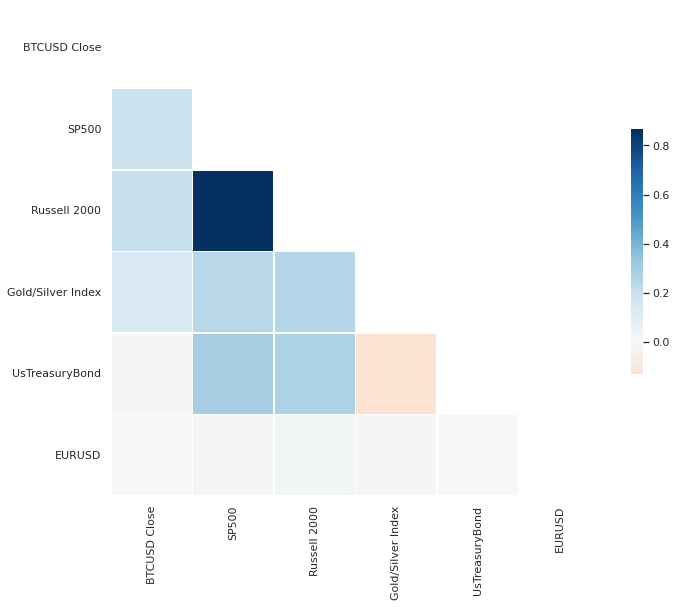

In [ ]:
correlation = log_returns.copy()
correlation
correlation.drop(
    ["BTCUSD Volume", "DAX", "SP500FutJune20", "VIX CBOE", "ETHUSD", "Oil", "Gold"],
    axis=1,
    inplace=True,
)
correlation = correlation.dropna()

# Plotting a diagonal correlation matrix
sns.set(style="white")

# Compute the correlation matrix
df = pd.DataFrame(correlation, columns=col_list)
corr = correlation.corr()
corr

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = "RdBu"

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(
    corr,
    mask=mask,
    cmap=cmap,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
)

## Analysis of BTC autocorrelation

In [ ]:
# https://www.statology.org/ljung-box-test-python/

# test p-value for lag X if resisuals independently distributied or not (ljung box)

import statsmodels.api as sm

#load data series
data_ljung = log_ret_btc

#view first ten rows of data series 
data_ljung[:5]

#fit ARMA model to dataset
res = sm.tsa.ARMA(data["BTCUSD Close"], (1,1)).fit(disp=-1)

#perform Ljung-Box test on residuals with lag=2
sm.stats.acorr_ljungbox(res.resid, lags=[1])  # p-value (second value in array) for lag 1 much greater than 0.05 --> residuals probably independently distributed

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


(array([0.00037181]), array([0.98461585]))

## Analysis of individaul input features (Plots)

### Bitcoin

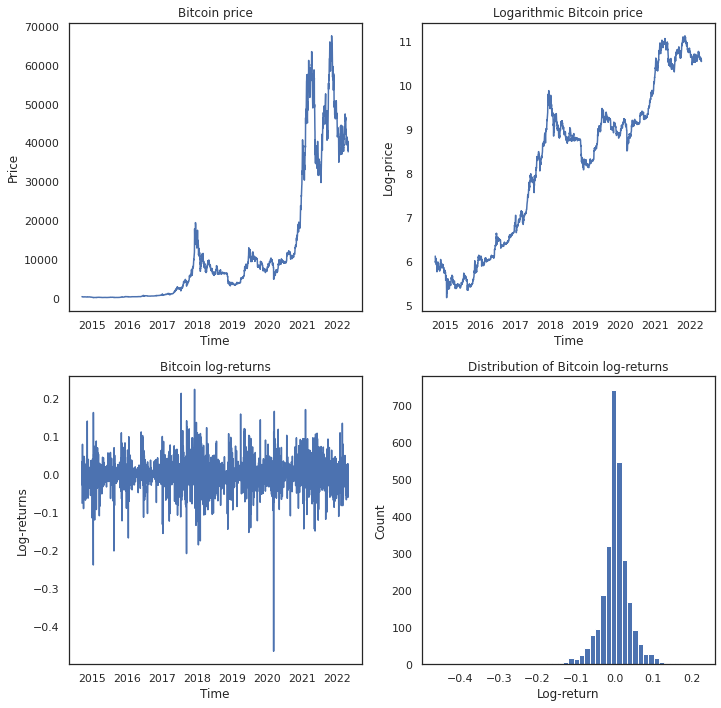

In [ ]:
# Bitcoin

fig = plt.figure(figsize=(20, 10))

ax1 = plt.subplot2grid((2,4), (0,0)) 
ax2 = plt.subplot2grid((2,4), (0,1)) 
ax3 = plt.subplot2grid((2,4), (1,0)) 
ax4 = plt.subplot2grid((2,4), (1,1))

# log price plot
ax1.plot(prices['BTCUSD Close'], 'b')
ax1.set_xlabel("Time")
ax1.set_ylabel("Price")
ax1.set_title("Bitcoin price")

# log price plot
ax2.plot(log_prices['BTCUSD Close'], 'b')
ax2.set_xlabel("Time")
ax2.set_ylabel('Log-price')
ax2.set_title("Logarithmic Bitcoin price")

# log return plot
ax3.plot(log_returns['BTCUSD Close'], 'b')
ax3.set_xlabel("Time")
ax3.set_ylabel('Log-returns')
ax3.set_title("Bitcoin log-returns")
#ax3.legend()

# distribution of log returns
ax4.hist(log_returns['BTCUSD Close'], bins = 50)
ax4.set_title("Distribution of Bitcoin log-returns")
ax4.set_xlabel("Log-return")
ax4.set_ylabel('Count')

fig.tight_layout()

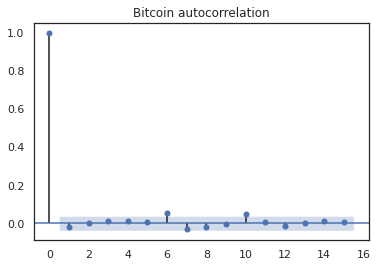

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

autocorr = log_returns['BTCUSD Close'].dropna()
# Calculate the ACF (via statsmodel)
plot_acf(autocorr, lags=15)
plt.title("Bitcoin autocorrelation")
# Show the data as a plot (via matplotlib)
plt.show()

In [ ]:
# min max Log returns
feature = log_returns['BTCUSD Close'].copy()
feature = feature.dropna()

from scipy.stats import skew
from scipy.stats import kurtosis


positive =[feature >=0 ]
positive_returns = np.count_nonzero(positive)


print("Min: ", np.min(feature))
print("Max: ", np.max(feature))
print("Mean: ",np.mean(feature))

print("Skewness: ", skew(feature)) #function calculates the skewness of the data set.
print("Kurtosis: ", kurtosis(feature, fisher=True)) # 0 would represent normal distribution; <0 means heavier tails than normal

print("positive returns: ", positive_returns)
print("negative returns: ",len(feature)-positive_returns)


Min:  -0.46473017533977296
Max:  0.22511895434132784
Mean:  0.0015860517067018563
Skewness:  -0.7672327765683538
Kurtosis:  11.112188511211164
positive returns:  1504
negative returns:  1278


### S&P 500

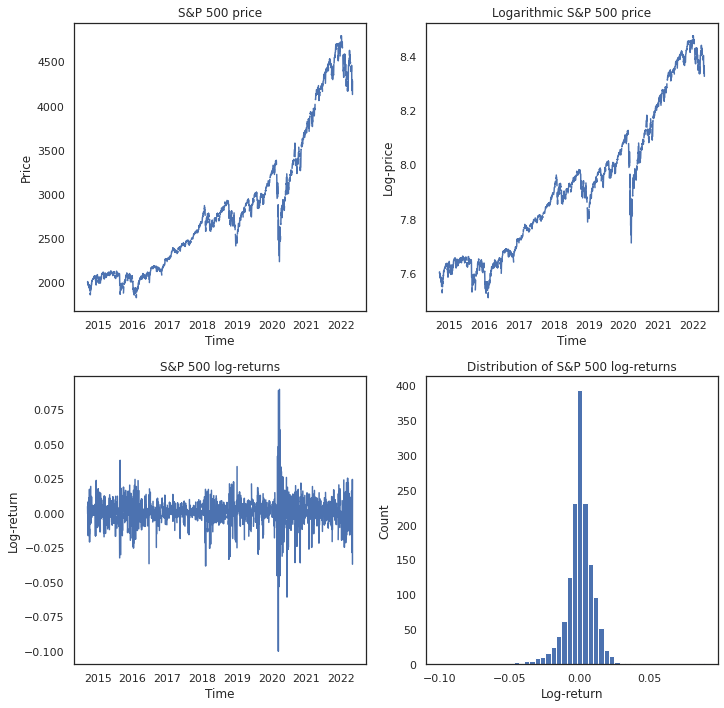

In [ ]:
# S&P 500

fig = plt.figure(figsize=(20, 10))

ax1 = plt.subplot2grid((2,4), (0,0)) 
ax2 = plt.subplot2grid((2,4), (0,1)) 
ax3 = plt.subplot2grid((2,4), (1,0)) 
ax4 = plt.subplot2grid((2,4), (1,1)) 

# price plot
ax1.plot(prices['SP500'], 'b')
ax1.set_xlabel("Time")
ax1.set_ylabel('Price')
ax1.set_title("S&P 500 price")

# price plot
ax2.plot(log_prices['SP500'], 'b')
ax2.set_xlabel("Time")
ax2.set_ylabel('Log-price')
ax2.set_title("Logarithmic S&P 500 price")

# log return plot
ax3.plot(log_returns['SP500'], 'b')
ax3.set_xlabel("Time")
ax3.set_ylabel('Log-return')
ax3.set_title("S&P 500 log-returns")

# distribution of log returns
ax4.hist(log_returns['SP500'], bins = 50)
ax4.set_title("Distribution of S&P 500 log-returns")
ax4.set_xlabel("Log-return")
ax4.set_ylabel('Count')

fig.tight_layout()

In [ ]:
# min max Log returns
feature = log_returns['SP500'].copy()
feature = feature.dropna()

from scipy.stats import skew


positive =[feature >=0 ]
positive_returns = np.count_nonzero(positive)


print("Min: ", np.min(feature))
print("Max: ", np.max(feature))
print("Mean: ",np.mean(feature))

print("Skewness: ", skew(feature)) #function calculates the skewness of the data set.
print("Kurtosis: ", kurtosis(feature, fisher=True)) # 0 would represent normal distribution; <0 means heavier tails than normal

print("positive returns: ", positive_returns)
print("negative returns: ",len(feature)-positive_returns)


Min:  -0.09994485240247351
Max:  0.08968323251796326
Mean:  0.00048040233629290026
Skewness:  -0.2171949305793006
Kurtosis:  13.434474635995926
positive returns:  820
negative returns:  683


### Russell 2000

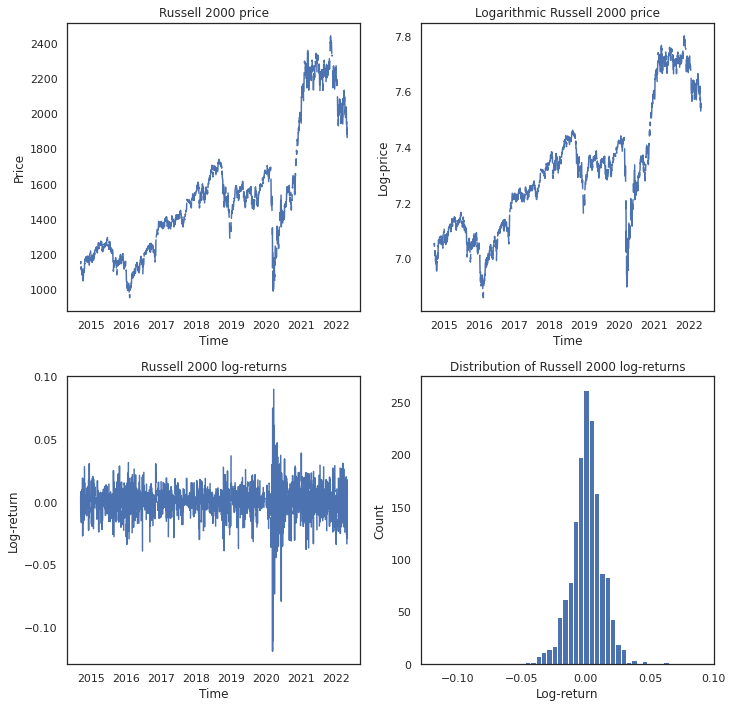

In [ ]:
# Russell 2000

fig = plt.figure(figsize=(20, 10))

ax1 = plt.subplot2grid((2,4), (0,0)) 
ax2 = plt.subplot2grid((2,4), (0,1)) 
ax3 = plt.subplot2grid((2,4), (1,0)) 
ax4 = plt.subplot2grid((2,4), (1,1)) 

# price plot
ax1.plot(prices['Russell 2000'], 'b')
ax1.set_xlabel("Time")
ax1.set_ylabel('Price')
ax1.set_title("Russell 2000 price")

# price plot
ax2.plot(log_prices['Russell 2000'], 'b')
ax2.set_xlabel("Time")
ax2.set_ylabel('Log-price')
ax2.set_title("Logarithmic Russell 2000 price")

# log return plot
ax3.plot(log_returns['Russell 2000'], 'b')
ax3.set_xlabel("Time")
ax3.set_ylabel('Log-return')
ax3.set_title("Russell 2000 log-returns")

# distribution of log returns
ax4.hist(log_returns['Russell 2000'], bins = 50)
ax4.set_title("Distribution of Russell 2000 log-returns")
ax4.set_xlabel("Log-return")
ax4.set_ylabel('Count')

fig.tight_layout()

In [ ]:
# min max Log returns
feature = log_returns['Russell 2000'].copy()
feature = feature.dropna()

from scipy.stats import skew


positive =[feature >=0 ]
positive_returns = np.count_nonzero(positive)


print("Min: ", np.min(feature))
print("Max: ", np.max(feature))
print("Mean: ",np.mean(feature))

print("Skewness: ", skew(feature)) #function calculates the skewness of the data set.
print("Kurtosis: ", kurtosis(feature, fisher=True)) # 0 would represent normal distribution; <0 means heavier tails than normal

print("positive returns: ", positive_returns)
print("negative returns: ",len(feature)-positive_returns)


Min:  -0.11857725934831777
Max:  0.08976265458668446
Mean:  0.00034446442086459643
Skewness:  -0.6961751777228038
Kurtosis:  9.545131122175542
positive returns:  806
negative returns:  697


### EUR/USD

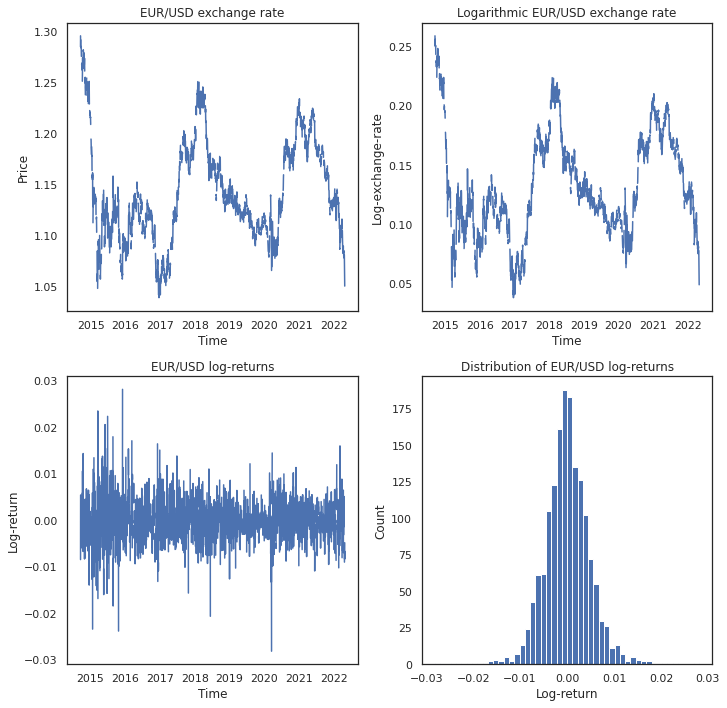

In [ ]:
# EUR/USD

fig = plt.figure(figsize=(20, 10))

ax1 = plt.subplot2grid((2,4), (0,0)) 
ax2 = plt.subplot2grid((2,4), (0,1)) 
ax3 = plt.subplot2grid((2,4), (1,0)) 
ax4 = plt.subplot2grid((2,4), (1,1)) 

# price plot
ax1.plot(prices['EURUSD'], 'b')
ax1.set_xlabel("Time")
ax1.set_ylabel('Price')
ax1.set_title("EUR/USD exchange rate")

# price plot
ax2.plot(log_prices['EURUSD'], 'b')
ax2.set_xlabel("Time")
ax2.set_ylabel('Log-exchange-rate')
ax2.set_title("Logarithmic EUR/USD exchange rate")

# log return plot
ax3.plot(log_returns['EURUSD'], 'b')
ax3.set_xlabel("Time")
ax3.set_ylabel('Log-return')
ax3.set_title("EUR/USD log-returns")

# distribution of log returns
ax4.hist(log_returns['EURUSD'], bins = 50)
ax4.set_title("Distribution of EUR/USD log-returns")
ax4.set_xlabel("Log-return")
ax4.set_ylabel('Count')

fig.tight_layout()

In [ ]:
# min max Log returns
feature = log_returns['EURUSD'].copy()
feature = feature.dropna()

from scipy.stats import skew


positive =[feature >=0 ]
positive_returns = np.count_nonzero(positive)


print("Min: ", np.min(feature))
print("Max: ", np.max(feature))
print("Mean: ",np.mean(feature))

print("Skewness: ", skew(feature)) #function calculates the skewness of the data set.
print("Kurtosis: ", kurtosis(feature, fisher=True)) # 0 would represent normal distribution; <0 means heavier tails than normal

print("positive returns: ", positive_returns)
print("negative returns: ",len(feature)-positive_returns)


Min:  -0.028144080771162875
Max:  0.02814535106681541
Mean:  5.543151779916974e-06
Skewness:  0.06914088497106109
Kurtosis:  3.236501527844731
positive returns:  785
negative returns:  799


### US Treasury Note 10 Year Yield

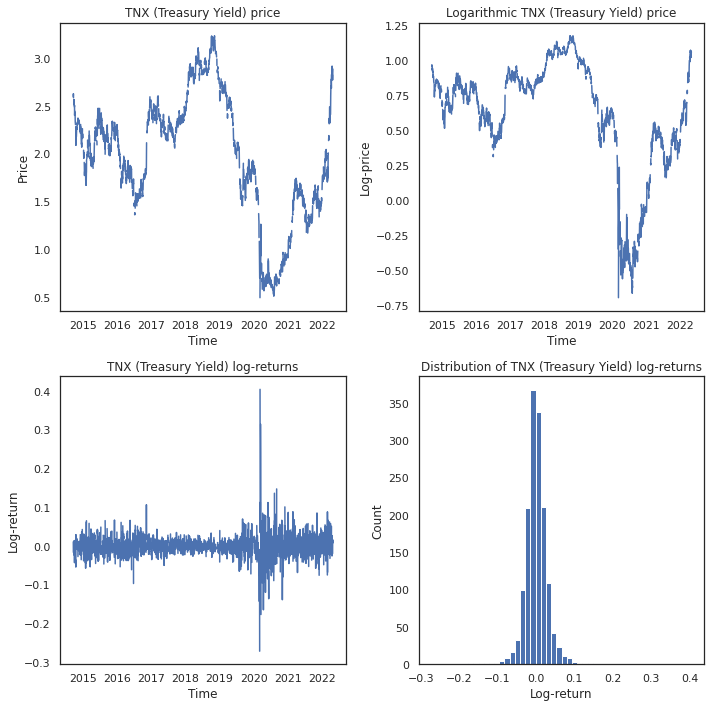

In [ ]:
# UsTreasuryBond: TNX Index

fig = plt.figure(figsize=(20, 10))

ax1 = plt.subplot2grid((2,4), (0,0)) 
ax2 = plt.subplot2grid((2,4), (0,1)) 
ax3 = plt.subplot2grid((2,4), (1,0)) 
ax4 = plt.subplot2grid((2,4), (1,1)) 

# price plot
ax1.plot(prices['UsTreasuryBond'], 'b')
ax1.set_xlabel("Time")
ax1.set_ylabel('Price')
ax1.set_title("TNX (Treasury Yield) price")

# price plot
ax2.plot(log_prices['UsTreasuryBond'], 'b')
ax2.set_xlabel("Time")
ax2.set_ylabel('Log-price')
ax2.set_title("Logarithmic TNX (Treasury Yield) price")

# log return plot
ax3.plot(log_returns['UsTreasuryBond'], 'b')
ax3.set_xlabel("Time")
ax3.set_ylabel('Log-return')
ax3.set_title("TNX (Treasury Yield) log-returns")

# distribution of log returns
ax4.hist(log_returns['UsTreasuryBond'], bins = 50)
ax4.set_title("Distribution of TNX (Treasury Yield) log-returns")
ax4.set_xlabel("Log-return")
ax4.set_ylabel('Count')

fig.tight_layout()

In [ ]:
# min max Log returns
feature = log_returns['UsTreasuryBond'].copy()
feature = feature.dropna()

from scipy.stats import skew


positive =[feature >=0 ]
positive_returns = np.count_nonzero(positive)


print("Min: ", np.min(feature))
print("Max: ", np.max(feature))
print("Mean: ",np.mean(feature))

print("Skewness: ", skew(feature)) #function calculates the skewness of the data set.
print("Kurtosis: ", kurtosis(feature, fisher=True)) # 0 would represent normal distribution; <0 means heavier tails than normal

print("positive returns: ", positive_returns)
print("negative returns: ",len(feature)-positive_returns)


Min:  -0.2712590379982701
Max:  0.40479689084622306
Mean:  0.0003003674522643031
Skewness:  1.5649482639056504
Kurtosis:  28.14950387441165
positive returns:  744
negative returns:  757


### Gold & Silver

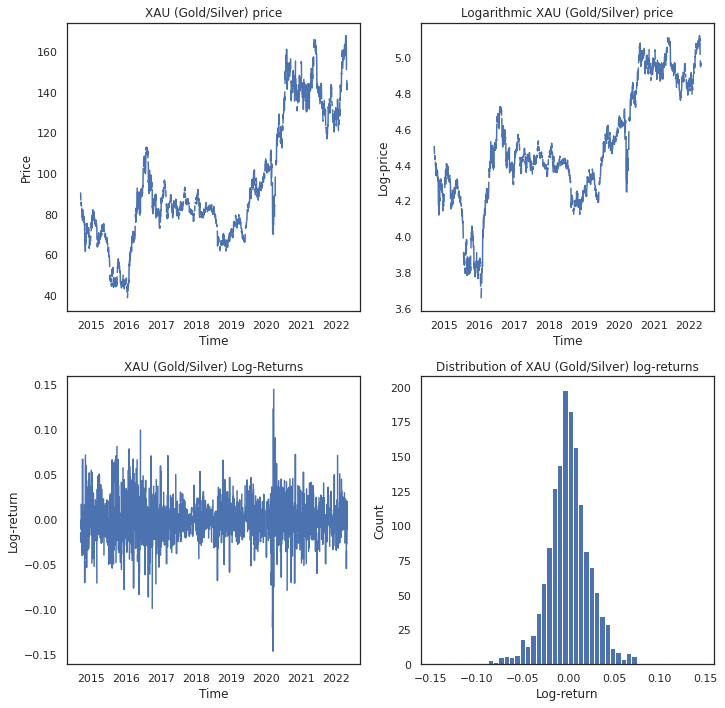

In [ ]:
# Gold & Silver Index : ^XAU

fig = plt.figure(figsize=(20, 10))

ax1 = plt.subplot2grid((2,4), (0,0)) 
ax2 = plt.subplot2grid((2,4), (0,1)) 
ax3 = plt.subplot2grid((2,4), (1,0)) 
ax4 = plt.subplot2grid((2,4), (1,1)) 

# price plot
ax1.plot(prices['Gold/Silver Index'], 'b')
ax1.set_xlabel("Time")
ax1.set_ylabel('Price')
ax1.set_title("XAU (Gold/Silver) price")

# price plot
ax2.plot(log_prices['Gold/Silver Index'], 'b')
ax2.set_xlabel("Time")
ax2.set_ylabel('Log-price')
ax2.set_title("Logarithmic XAU (Gold/Silver) price")

# log return plot
ax3.plot(log_returns['Gold/Silver Index'], 'b')
ax3.set_xlabel("Time")
ax3.set_ylabel('Log-return')
ax3.set_title("XAU (Gold/Silver) Log-Returns")

# distribution of log returns
ax4.hist(log_returns['Gold/Silver Index'], bins = 50)
ax4.set_title("Distribution of XAU (Gold/Silver) log-returns")
ax4.set_xlabel("Log-return")
ax4.set_ylabel('Count')

fig.tight_layout()

In [ ]:
# min max Log returns
feature = log_returns['Gold/Silver Index'].copy()
feature = feature.dropna()

from scipy.stats import skew


positive =[feature >=0 ]
positive_returns = np.count_nonzero(positive)


print("Min: ", np.min(feature))
print("Max: ", np.max(feature))
print("Mean: ",np.mean(feature))

print("Skewness: ", skew(feature)) #function calculates the skewness of the data set.
print("Kurtosis: ", kurtosis(feature, fisher=True)) # 0 would represent normal distribution; <0 means heavier tails than normal

print("positive returns: ", positive_returns)
print("negative returns: ",len(feature)-positive_returns)

Min:  -0.14604639541920994
Max:  0.1445373516396168
Mean:  0.00025296935517981977
Skewness:  -0.059135426049878634
Kurtosis:  3.3144754634568967
positive returns:  745
negative returns:  758


### Density plot of all features

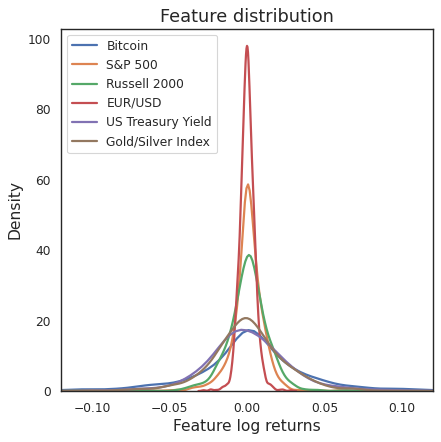

In [ ]:
log_features = log_returns.copy()

figure(figsize=(6, 6), dpi=80)

sns.set_style("white")
parameters = {'axes.labelsize': 14,
          'axes.titlesize': 16}
plt.rcParams.update(parameters)
 
# plotting both distibutions on the same figure
fig = sns.kdeplot(log_features['BTCUSD Close'], label = 'Bitcoin', linewidth=2)
fig = sns.kdeplot(log_features['SP500'], label = 'S&P 500', linewidth=2)
fig = sns.kdeplot(log_features['Russell 2000'], label = 'Russell 2000', linewidth=2)
fig = sns.kdeplot(log_features['EURUSD'], label = 'EUR/USD', linewidth=2)
fig = sns.kdeplot(log_features['UsTreasuryBond'], label = 'US Treasury Yield', linewidth=2)
fig = sns.kdeplot(log_features['Gold/Silver Index'], label = 'Gold/Silver Index', linewidth=2)

plt.xlim([-0.12, 0.12])

plt.title('Feature distribution')
plt.xlabel("Feature log returns")
plt.ylabel('Density')
plt.legend(loc ='upper left')
plt.show()